# **Synthesis project**

---



Team 3: Joaquin Arenas (1673338), Martina Carretta (1673930), Mariona Pla (1616474), Ares Sellart (1665890)

# Import the necessary libraries

In [1]:
!pip install -q pdfplumber seaborn matplotlib scikit-learn xgboost
!pip install -q openpyxl
!pip install -q keras
!pip install -q tensorflow

In [148]:
# Standard library imports
import calendar
import itertools
from datetime import datetime, timedelta
from math import sqrt

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdfplumber
import seaborn as sns
import xgboost as xgb
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

2024-05-19 19:12:37.795636: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 19:12:37.806468: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 19:12:38.256740: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 19:12:40.091218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 19:13:05.998566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [4]:
# Function to retrieve datasets from the datasets.zip and the images from figures.zip in the case the last person to use the code uploaded them
# otherwise, it will pass. 
# It will unzip the file and save it to the datasets directory if it exists, otherwise it will just create the directory.

import os
import zipfile

def unzip_file(zip_filepath, dest_dir):
    # Check if zip file exists
    if not os.path.exists(zip_filepath):
        print(f"Zip file {zip_filepath} does not exist. Skipping.")
        return

    # Check if destination directory exists
    if not os.path.exists(dest_dir):
        # If not, create the directory
        os.makedirs(dest_dir)

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

unzip_file('datasets.zip', 'datasets')
unzip_file('figures.zip', 'figures')


# Function to save the plots, histograms and forecasts
def save_pic (file_name): 
    # Define the directory and filename
    dir_name = 'figures'
    # Check if the directory exists, if not, create it
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # Save the figure
    plt.savefig(f'{dir_name}/{file_name}')

# Function to save 2 of the datasets:
def save_csv (dataframe, file_name):
    # Define the directory and filename
    dir_name = 'CSVs'

    # Check if the directory exists, if not, create it
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # Save the dataframe to csv
    dataframe.to_csv(f'{dir_name}/{file_name}', index=False)

# Data collection and processing

In [5]:
def extract_table_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[0]
        table = page.extract_table()
        # Dropping the first two rows
        table = table[2:]
        df = pd.DataFrame(table[1:], columns=table[0])  # Assuming the first row contains column headers
    return df

## Max capacity dataset

In [6]:
max_capacity = extract_table_from_pdf('datasets/EE_capacitat_aules_.pdf')

In [7]:
max_capacity.rename(columns={'Capacitat\nClasse': 'Capacitat Classe'}, inplace=True)
max_capacity.rename(columns={'Capacitat\nExàmens': 'Capacitat Exàmens'}, inplace=True)

In [8]:
def convert_to_int(column):
    try:
        return int(column)
    except ValueError:
        # If the value can't be converted to int, return NaN
        return float('NaN')

def convert_to_float(column):
    try:
        return float(column)
    except ValueError:
        # If the value can't be converted to int, return NaN
        return float('NaN')

max_capacity['Capacitat Classe'] = max_capacity['Capacitat Classe'].apply(convert_to_int)
max_capacity['Capacitat Exàmens'] = max_capacity['Capacitat Exàmens'].apply(convert_to_int)

In [9]:
max_capacity

,AULA,Capacitat Classe,Capacitat Exàmens
0,Q1/1003,90,50.0
1,Q1/1007,90,50.0
2,Q1/1011,162,80.0
3,Q2/1003,63,35.0
4,Q2/1005,63,35.0
5,Q2/1009,90,50.0
6,Q2/1013,90,50.0
7,Q3/0003,100,60.0
8,Q3/0009,48,24.0
9,Q3/0013,48,24.0


In [10]:
if isinstance(max_capacity, pd.DataFrame):
    print("The object is a DataFrame.")
else:
    print("The object is not a DataFrame.")

The object is a DataFrame.


## Occupation dataset

In [11]:

# def split_intervals(row):
#     start = row['Hora inicial']
#     end = row['Hora final']
#     interval_start = start
#     interval_end = end
#     while interval_start < end:
#         if is_not_oclock(interval_start):
#             interval_start = add_minutes_to_time(interval_start, -30)
#         interval_end = min(add_minutes_to_time(interval_start, 60), end)
#         if is_not_oclock(interval_end):
#             interval_end = add_minutes_to_time(interval_end, 30)
#         yield {
#             'Data inicial': row['Data inicial'],
#             'Hora inicial': interval_start,
#             'Data final': row['Data final'],
#             'Hora final': interval_end,
#             'Espai': row['Espai'],
#             'Estudi': row['Estudi'],
#             'Activitat': row['Activitat'],
#             'Alumnes matriculats': row['Alumnes matriculats']
#         }
#         interval_start = interval_end


def is_not_oclock(hour):
    # Check if the minutes part is non-zero
    if hour.minute != 0:
      return True
    else:
      return False

def add_minutes_to_time(time_obj, minutes):
    # Combine the time object with today's date
    datetime_obj = datetime.combine(datetime.today(), time_obj)
    # Add the timedelta
    datetime_obj += timedelta(minutes=minutes)
    # Return the new time object
    return datetime_obj.time()

def split_intervals(row):
    start = row['Hora inicial']
    end = row['Hora final']
    alumnes = row['Alumnes matriculats']
    interval_start = start
    interval_end = end
    alumnes2 = alumnes
    while interval_start < end:
        if is_not_oclock(interval_start): # Initial time is not :00
              # Subtract 30 minutes from the initial time
              interval_start = add_minutes_to_time(interval_start, -30)
              if pd.notnull(alumnes): # Check if 'alumnes' is not NaN
                  alumnes = alumnes/2 # Divide by 2 because we have added 30 minutes to that time

        interval_end = min(add_minutes_to_time(interval_start, 60), end)

        if is_not_oclock(interval_end): # Final time is not :00
              # Add 30 minutes to the final time
              interval_end = add_minutes_to_time(interval_end, 30)
              if pd.notnull(alumnes): # Check if 'alumnes' is not NaN
                  alumnes = alumnes/2 # Divide by 2 because we have added 30 minutes to that time\

        yield {
            'Data inicial': row['Data inicial'],
            'Hora inicial': interval_start,
            'Data final': row['Data final'],
            'Hora final': interval_end,
            'Espai': row['Espai'],
            'Estudi': row['Estudi'],
            'Activitat': row['Activitat'],
            'Alumnes matriculats': alumnes
        }
        interval_start = interval_end
        alumnes = alumnes2

---
It is observed that there are many rows which don't contain values in the "Data inicial" column as well as the "Hora inicial", "Data final", "Hora final" and "Total d'hores". This is due to 2 or more degrees sharing a classroom, usually in order to take the same class, so the occupation should only be counted once. In order to work comfortably, there will be a drop of all rows containing a NaN value in such rows.

---

---
Since the consumption files are ordered in a way where each row is an hour, it is convenient to split those rows of the occupation dataframe which have a duration of more than 1 hour into rows of 1h duration in order to manage both files simultaneously in an easier way.

---

In [12]:
file_paths = ['datasets/ocupacio_enginyeria_2018.xlsx',
              'datasets/ocupacio_enginyeria_2019.xlsx',
              'datasets/ocupacio_enginyeria_2020.xlsx',
              'datasets/ocupacio_enginyeria_2021.xlsx',
              'datasets/ocupacio_enginyeria_2022.xlsx',
              'datasets/ocupacio_enginyeria_2023.xlsx',
              'datasets/ocupacio_enginyeria_2024.xlsx']

hourly_occupation_data = {}  # Dictionary to store hourly_occupation dataframes

for file_path in file_paths:
    occupation = pd.read_excel(file_path, skiprows=4)
    # Drop useless columns
    del occupation["Observacions"]
    del occupation["Modalitat docencia"]

    search_string = 'Sense grup de matricula'
    rows_containing_string = occupation['Alumnes matriculats'].str.contains(search_string, na=False)
    occupation = occupation[~rows_containing_string]

    # Preprocess time columns to handle missing or inconsistent values
    occupation['Hora inicial'] = occupation['Hora inicial'].replace(" ", pd.NA)
    # occupation['Hora final'] = occupation['Hora final'].replace(" ", pd.NA)
    occupation.dropna(subset=['Hora inicial', 'Hora final'], inplace=True)

    # Convert column to datetime format
    occupation['Hora inicial'] = pd.to_datetime(occupation['Hora inicial'], format='%H:%M')
    occupation['Hora final'] = pd.to_datetime(occupation['Hora final'], format='%H:%M')
    occupation['Data inicial'] = pd.to_datetime(occupation['Data inicial'], format='%d/%m/%Y')
    occupation['Data final'] = pd.to_datetime(occupation['Data final'], format='%d/%m/%Y')

    # HANDLE :15
    # Find rows where 'Hora inicial' ends with :15
    rows_to_update_inicio = occupation[occupation['Hora inicial'].dt.minute == 15].index
    # Find rows where 'Hora final' ends with :15
    rows_to_update_final = occupation[occupation['Hora final'].dt.minute == 15].index
    # Update those rows to end with :00
    occupation.loc[rows_to_update_inicio, 'Hora inicial'] = occupation.loc[rows_to_update_inicio, 'Hora inicial'].apply(lambda x: x.replace(minute=0))
    occupation.loc[rows_to_update_final, 'Hora final'] = occupation.loc[rows_to_update_final, 'Hora final'].apply(lambda x: x.replace(minute=0))
    # Find rows where 'Hora inicial' ends with :45
    rows_to_update_inicio = occupation[occupation['Hora inicial'].dt.minute == 45].index
    # Find rows where 'Hora final' ends with :45
    rows_to_update_final = occupation[occupation['Hora final'].dt.minute == 45].index
    # Update those rows to end with :00
    occupation.loc[rows_to_update_inicio, 'Hora inicial'] = occupation.loc[rows_to_update_inicio, 'Hora inicial'].apply(lambda x: x.replace(minute=0))
    occupation.loc[rows_to_update_final, 'Hora final'] = occupation.loc[rows_to_update_final, 'Hora final'].apply(lambda x: x.replace(minute=0))
    # Convert back to time
    occupation['Hora inicial'] = occupation['Hora inicial'].dt.time
    occupation['Hora final'] = occupation['Hora final'].dt.time

    # Go to numeric
    occupation['Alumnes matriculats'] = pd.to_numeric(occupation['Alumnes matriculats'], errors='coerce')

    # Create a list of dictionaries for each 1-hour interval
    new_rows = [row for _, row in occupation.iterrows() for row in split_intervals(row)]
    # Create a new DataFrame from the list of dictionaries
    new_occupation = pd.DataFrame(new_rows)

    # Additional operations specific to each dataset
    average_occupation = new_occupation['Alumnes matriculats'].mean()
    new_occupation['Alumnes matriculats'] = new_occupation['Alumnes matriculats'].fillna(average_occupation)

    hourly_occupation = new_occupation.groupby(['Data inicial', 'Hora inicial'])['Alumnes matriculats'].sum().reset_index()

    # Store the hourly_occupation dataframe for this year in the dictionary
    year = file_path.split('_')[-1].split('.')[0]  # Extract year from file name
    hourly_occupation_data[year] = hourly_occupation

# Concatenate the dataframes
concatenated_hourly_occupation = pd.concat(hourly_occupation_data.values(), ignore_index=True)

occupation = concatenated_hourly_occupation # Concatenated is the total dataframe

In [13]:
unique_categories = occupation['Hora inicial'].unique()
print(unique_categories)

[datetime.time(15, 0) datetime.time(16, 0) datetime.time(17, 0)
 datetime.time(18, 0) datetime.time(19, 0) datetime.time(14, 0)
 datetime.time(9, 0) datetime.time(10, 0) datetime.time(11, 0)
 datetime.time(12, 0) datetime.time(13, 0) datetime.time(20, 0)
 datetime.time(8, 0) datetime.time(21, 0)]


In [14]:
occupation

,Data inicial,Hora inicial,Alumnes matriculats
0,2018-01-01,15:00:00,0.0
1,2018-01-01,16:00:00,0.0
2,2018-01-03,16:00:00,0.0
3,2018-01-03,17:00:00,0.0
4,2018-01-03,18:00:00,0.0
...,...,...,...
16906,2024-05-31,15:00:00,323.0
16907,2024-05-31,16:00:00,326.0
16908,2024-05-31,17:00:00,123.0
16909,2024-05-31,18:00:00,70.0


---
The rows have indeed been divided into rows of one natural hour and the students have been divided into half the amount whenever two classes started and ended back to back in a :30 time

---

---
The room occupation effect on the energy consumption should be checked. In order to do so, correlation should be used.

---


In [15]:
for index, row in occupation.iterrows(): # Fill rows where max capacity is empty with 60%
    if pd.isnull(row['Alumnes matriculats']):
        classroom = row['Espai']
        max_capacity_row = max_capacity[max_capacity['AULA'] == classroom]
        if not max_capacity_row.empty:
            max_capacity_value = max_capacity_row.iloc[0]['Capacitat Classe']
            max_capacity_value*=0.6
            occupation.at[index, 'Alumnes matriculats'] = max_capacity_value

In [16]:
occupation[2373	:2383]

,Data inicial,Hora inicial,Alumnes matriculats
2373,2018-11-29,15:00:00,179.0
2374,2018-11-29,16:00:00,179.0
2375,2018-11-29,17:00:00,72.0
2376,2018-11-29,18:00:00,48.0
2377,2018-11-29,19:00:00,0.0
2378,2018-11-30,08:00:00,346.0
2379,2018-11-30,09:00:00,703.5
2380,2018-11-30,10:00:00,589.0
2381,2018-11-30,11:00:00,444.0
2382,2018-11-30,12:00:00,347.5


Still, not all the classes do not contain the capacity. The reason behind this is that not all the classes are present in the max_capacity dataset.

To solve this, we will work with the average occupation value.

In [17]:
average_occupation = occupation['Alumnes matriculats'].mean()
average_occupation

212.1080953225711

In [18]:
occupation['Alumnes matriculats'] = occupation['Alumnes matriculats'].fillna(average_occupation)


In [19]:
occupation['Alumnes matriculats'] = occupation['Alumnes matriculats'].apply(convert_to_float)
occupation

,Data inicial,Hora inicial,Alumnes matriculats
0,2018-01-01,15:00:00,0.0
1,2018-01-01,16:00:00,0.0
2,2018-01-03,16:00:00,0.0
3,2018-01-03,17:00:00,0.0
4,2018-01-03,18:00:00,0.0
...,...,...,...
16906,2024-05-31,15:00:00,323.0
16907,2024-05-31,16:00:00,326.0
16908,2024-05-31,17:00:00,123.0
16909,2024-05-31,18:00:00,70.0


This dataframe contains the faculty occupation hourly

In [20]:
start_date = occupation['Data inicial'].min()
end_date = occupation['Data inicial'].max()
print (start_date, end_date)

2018-01-01 00:00:00 2024-05-31 00:00:00


## Energy consumption - hourly

In [21]:
energy_consumption = pd.read_excel('datasets/Consum energia Q 2018-2023 horari.xlsx', skiprows=14)
energy_consumption

,Date,Hour,Q-Enginyeria-Total [kWh],Unnamed: 3
0,2018-01-01 00:00:00,2018-01-01 00:00:00,177.000000,NaN
1,2018-01-01 01:00:00,2018-01-01 01:00:00,177.440000,NaN
2,2018-01-01 02:00:00,2018-01-01 02:00:00,176.570000,NaN
3,2018-01-01 03:00:00,2018-01-01 03:00:00,174.980000,NaN
4,2018-01-01 04:00:00,2018-01-01 04:00:00,174.510000,NaN
...,...,...,...,...
53624,2024-02-13 08:00:00,2024-02-13 08:00:00,363.222567,NaN
53625,2024-02-13 09:00:00,2024-02-13 09:00:00,388.690476,NaN
53626,2024-02-13 10:00:00,2024-02-13 10:00:00,417.800000,NaN
53627,2024-02-13 11:00:00,2024-02-13 11:00:00,440.495455,NaN


In [22]:
columns_to_drop = ['Unnamed: 3']  #drop unseful or empty columns
energy_consumption.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
# Convert the value to float
energy_consumption['Q-Enginyeria-Total [kWh]'] = energy_consumption['Q-Enginyeria-Total [kWh]'].apply(convert_to_float)

In [24]:
energy_consumption['Hour'] = pd.to_datetime(energy_consumption['Hour'], format='%H:%M').dt.time
energy_consumption['Date'] = pd.to_datetime(energy_consumption['Date']).dt.normalize()
energy_consumption_h = energy_consumption

In [25]:
start_date = energy_consumption_h['Date'].min()
end_date = energy_consumption_h['Date'].max()
energy_consumption_h

,Date,Hour,Q-Enginyeria-Total [kWh]
0,2018-01-01,00:00:00,177.000000
1,2018-01-01,01:00:00,177.440000
2,2018-01-01,02:00:00,176.570000
3,2018-01-01,03:00:00,174.980000
4,2018-01-01,04:00:00,174.510000
...,...,...,...
53624,2024-02-13,08:00:00,363.222567
53625,2024-02-13,09:00:00,388.690476
53626,2024-02-13,10:00:00,417.800000
53627,2024-02-13,11:00:00,440.495455


In [26]:
start_date

Timestamp('2018-01-01 00:00:00')

In [27]:
end_date

Timestamp('2024-02-13 00:00:00')

## Energy consumption - daily

In [91]:
energy_consumption_d = energy_consumption_h.copy()

In [92]:
energy_consumption_d['Date'] = pd.to_datetime(energy_consumption_d['Date'])
energy_consumption_d['Date'] = energy_consumption_d['Date'].dt.date
energy_consumption_d = energy_consumption_d.groupby('Date')['Q-Enginyeria-Total [kWh]'].sum().reset_index()

In [93]:
energy_consumption_d

,Date,Q-Enginyeria-Total [kWh]
0,2018-01-01,4574.100000
1,2018-01-02,4732.650000
2,2018-01-03,5002.980000
3,2018-01-04,5012.830000
4,2018-01-05,4987.020000
...,...,...
2230,2024-02-09,5667.725649
2231,2024-02-10,2929.404762
2232,2024-02-11,2840.428571
2233,2024-02-12,6278.612381


## Energy consumption - monthly


In [31]:
energy_consumption_m = energy_consumption_d.copy()

In [32]:
# Convert 'Date' column to datetime if it's not already
energy_consumption_m['Date'] = pd.to_datetime(energy_consumption_m['Date'])

# Set 'Date' column as the index
energy_consumption_m.set_index('Date', inplace=True)

# Resample the data to monthly frequency and sum the values for each month
energy_consumption_m = energy_consumption_m.resample('ME').sum()

# Reset index to make 'Date' a regular column again
energy_consumption_m.reset_index(inplace=True)
energy_consumption_m

,Date,Q-Enginyeria-Total [kWh]
0,2018-01-31,203097.866670
1,2018-02-28,201824.740000
2,2018-03-31,198795.750000
3,2018-04-30,191264.500000
4,2018-05-31,180644.145990
...,...,...
69,2023-10-31,197906.727273
70,2023-11-30,169001.696499
71,2023-12-31,148096.965839
72,2024-01-31,152176.577922


In [33]:
# Extract year and month from the 'Date' column
energy_consumption_m['Year'] = energy_consumption_m['Date'].dt.year
energy_consumption_m['Month'] = energy_consumption_m['Date'].dt.month

# Convert month numeric into month names
energy_consumption_m['Month'] = energy_consumption_m['Month'].apply(lambda x: calendar.month_name[x])

# Drop the 'Date' column if it's no longer needed
energy_consumption_m.drop(columns=['Date'], inplace=True)

In [34]:
# Reorder the columns
energy_consumption_m = energy_consumption_m[['Year', 'Month', 'Q-Enginyeria-Total [kWh]']]

energy_consumption_m

,Year,Month,Q-Enginyeria-Total [kWh]
0,2018,January,203097.866670
1,2018,February,201824.740000
2,2018,March,198795.750000
3,2018,April,191264.500000
4,2018,May,180644.145990
...,...,...,...
69,2023,October,197906.727273
70,2023,November,169001.696499
71,2023,December,148096.965839
72,2024,January,152176.577922


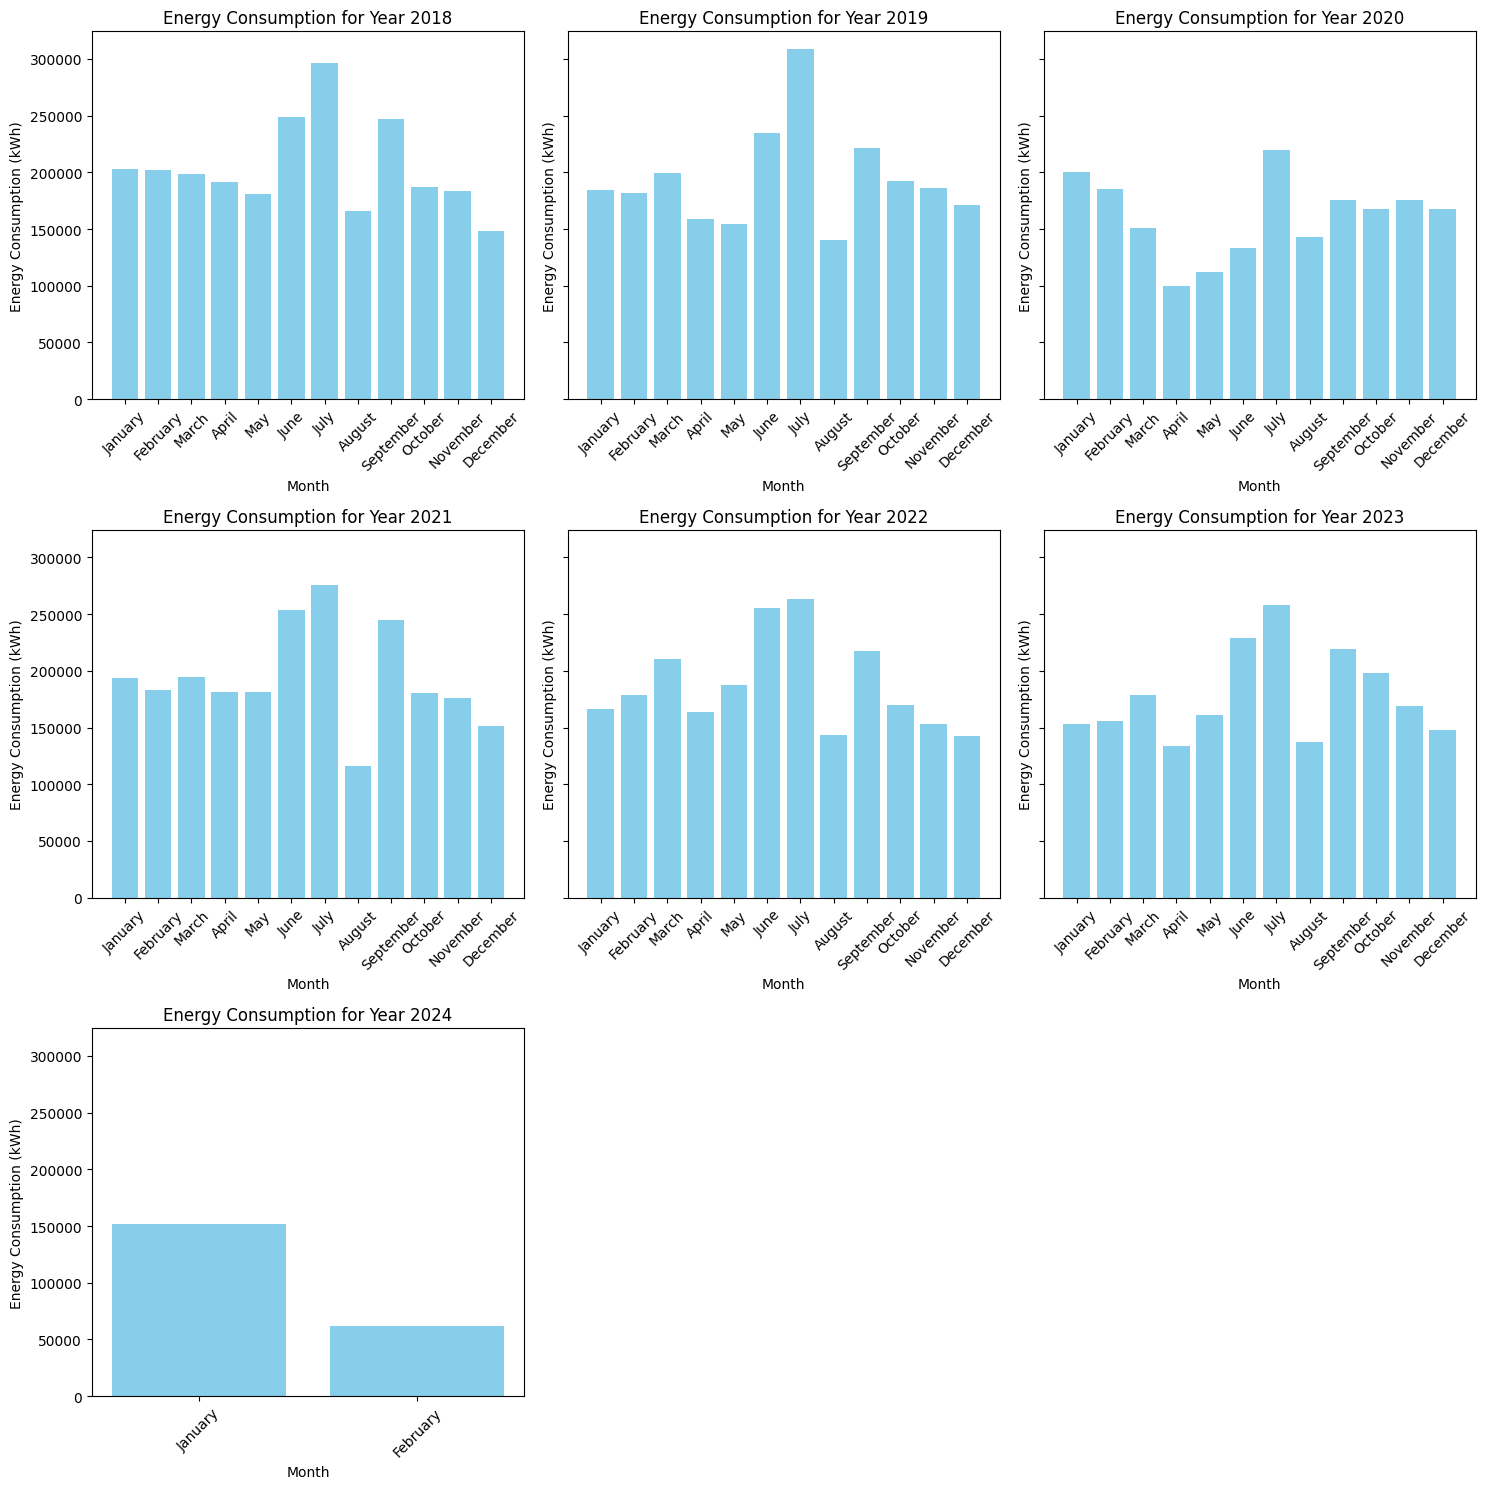

In [35]:
import math

# Determine the number of unique years in the dataset
num_years = energy_consumption_m['Year'].nunique()

# Calculate the number of rows and columns needed
n_cols = 3  # Fixed number of columns
n_rows = math.ceil(num_years / n_cols)

# Create a subplot grid based on the number of years
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharey=True)

# Flatten the axs array for easier indexing if more than one row
if n_rows > 1:
    axs = axs.flatten()

# Plot each year's data in the corresponding subplot
for i, (year, group) in enumerate(energy_consumption_m.groupby('Year')):
    ax = axs[i]  # Get the current axis
    ax.bar(group['Month'], group['Q-Enginyeria-Total [kWh]'], color='skyblue')
    ax.set_title(f'Energy Consumption for Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide any unused subplots if more than one row
if n_rows > 1:
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
save_pic ("Monthly_Energy_Consumption.png")
plt.show()


The low energy consumption value for February 2024 is due to the dataset only including data up to February 12th.

The reduction in energy consumption observed in 2020 from March onwards can be attributed to the profound impact of the pandemic. During this period, with the closure of the university and the shift to online classes, there was a notable decline in energy usage. This trend continued even after the initial lockdown period, with a modest decrease in energy consumption observed across all months.

Interestingly, August consistently exhibits the lowest consumption levels each year, primarily due to the cessation of air conditioning usage. However, the unexpected peak in consumption during July presents a puzzle, especially considering that the majority of classes typically conclude by this time. This anomaly may be ascribed to various factors, including the operation of summer courses, use of facilities by faculty members and administrative staff, and potential maintenance activities during the summer break.

Furthermore, it's important to note that the air conditioning cannot be switched off in specific faculty corridors, leading to continued operation even when classes are not in session. Additionally, machinery, servers, and other equipment remain active throughout July, contributing to overall energy consumption.

## PV energy production dataset

In [36]:
pv = pd.read_csv('datasets/Producció FV 2023 Q.csv', encoding='latin-1', delimiter=';')  # Try different encodings here

In [37]:
pv

,Nombre,Fecha,Producció (kWh)
0,Escuela de IngenierÃ­a - UAB,31/12/2023,"423,19"
1,Escuela de IngenierÃ­a - UAB,30/12/2023,"522,41"
2,Escuela de IngenierÃ­a - UAB,29/12/2023,"296,39"
3,Escuela de IngenierÃ­a - UAB,28/12/2023,"296,74"
4,Escuela de IngenierÃ­a - UAB,27/12/2023,"566,03"
...,...,...,...
117,Escuela de IngenierÃ­a - UAB,5/9/2023,"1249,62"
118,Escuela de IngenierÃ­a - UAB,4/9/2023,"1208,12"
119,Escuela de IngenierÃ­a - UAB,3/9/2023,"882,32"
120,Escuela de IngenierÃ­a - UAB,2/9/2023,"613,25"


In [38]:
# Convert 'Fecha' column to datetime
pv['Fecha'] = pd.to_datetime(pv['Fecha'], format='%d/%m/%Y')

In [39]:
# Convert 'Producció (kWh)' to float
pv['Producció (kWh)'] = pv['Producció (kWh)'].str.replace(',', '.').astype(float)

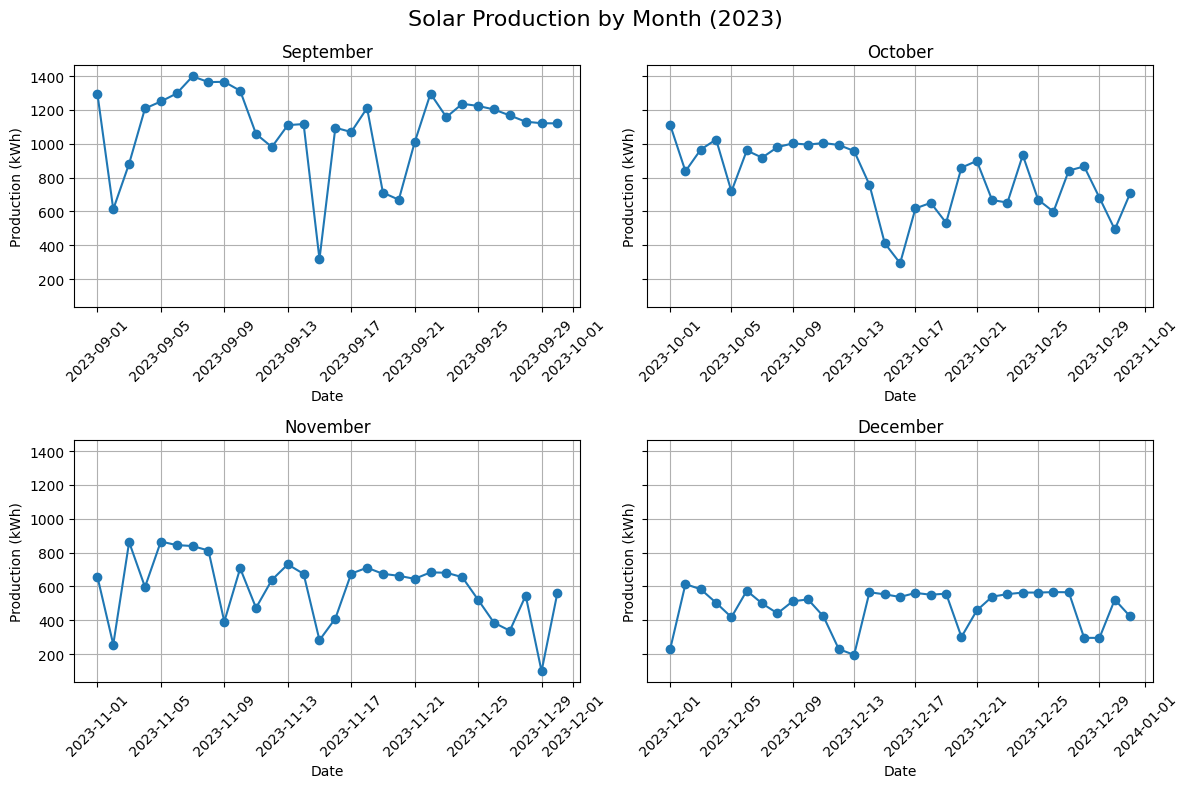

In [40]:
# Group data by month
monthly_data = pv.groupby(pv['Fecha'].dt.month)

# Plot data for each month
months = ['September', 'October', 'November', 'December']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True)  #shared y-axis
fig.suptitle('Solar Production by Month (2023)', fontsize=16)

for i, month in enumerate(months):
    ax = axes[i//2, i%2]
    month_data = monthly_data.get_group(i+9)  # i+9 as month numbers start from 1, and September is the 9th month
    ax.plot(month_data['Fecha'], month_data['Producció (kWh)'], marker='o')
    ax.set_title(month)
    ax.set_xlabel('Date')
    ax.set_ylabel('Production (kWh)')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
save_pic("Monthly_Solar_Production.png")
plt.show()

The overall solar photovoltaic (PV) production demonstrates a notable peak in September compared to subsequent months. This higher production can be attributed to the combined influence of warmer temperatures and longer daylight hours characteristic of the month.
However, the observed lower levels of PV production in some days necessitate further analysis; investigating the correlation between external factors such as outside temperature and weather patterns with PV production. Such analysis can provide insights into the interplay between environmental conditions and renewable energy generation, facilitating more effective planning and optimization strategies.


## Sensors dataset

In [41]:
sensors = pd.read_csv('datasets/historic sensors data.csv', encoding='latin-1', delimiter=',', skiprows=3)

**Dev ID, Localization**
- eui-24e124710c408089,     OpenLab – Laser room
- eui-24e124128c147444,     Biblio de Filosofia y Lletres
- eui-24e124128c147500,     OpenLab – Main Room
- eui-24e124128c147204, DigitalLab
- eui-24e124128c147499, AudioLab
- am307-9074, Computer room
- q4-1003-7456, Q4-1003
- eui-24e124128c147446
- eui-24e124128c147470

In [42]:
columns_to_drop = ['Unnamed: 0', 'result', '_start', '_stop', '_measurement']  #drop unuseful or empty columns
sensors.drop(columns_to_drop, axis=1, inplace=True)

In [43]:
print(sensors['_field'].unique())

['co2' 'humidity' 'light_level' 'o3' 'pm10' 'pm2_5' 'pressure'
 'temperature' 'tvoc' 'battery' 'activity' 'illumination' 'infrared'
 'infrared_and_visible']


In [44]:
print(sensors['location'].unique())

['am3019-testqc2090' 'am307-9074' 'eui-24e124128c147204'
 'eui-24e124128c147444' 'eui-24e124128c147446' 'eui-24e124128c147470'
 'eui-24e124128c147499' 'eui-24e124128c147500' 'eui-24e124710c408089'
 'eui-24e124725c461468' 'q4-1003-7456']


- 'CO2': Measurement of carbon dioxide concentration in the air.
- 'Humidity': Measurement of the amount of water vapor present in the air.
- 'Light_level': Measurement of the intensity of light in a given environment.
- 'O3': Measurement of ozone concentration in the air.
- 'PM10': Measurement of particulate matter with a diameter of 10 micrometers or less in the air.
- 'PM2_5': Measurement of particulate matter with a diameter of 2.5 micrometers or less in the air.
- 'Pressure': Measurement of the force exerted by the atmosphere per unit area.
- 'Temperature': Measurement of the degree of hotness or coldness of a body or environment.
- 'TVOC': Measurement of total volatile organic compounds in the air.
- 'Battery': Measurement of the remaining energy or charge level of a battery.
- 'Activity': Measurement of movement or action.
- 'Illumination': Measurement of the brightness of light in a given space.
- 'Infrared': Measurement of infrared radiation emitted or absorbed by objects.
- 'Infrared_and_visible': Measurement of both infrared and visible light wavelengths.

In [45]:
# Define the datetime formats to be used
datetime_formats = ['%Y-%m-%dT%H:%M:%S%z', '%Y-%m-%dT%H:%M:%S.%fZ']

# Convert '_time' column to datetime dtype, handling multiple formats and parsing errors
for fmt in datetime_formats:
    try:
        sensors['_time'] = pd.to_datetime(sensors['_time'], format=fmt)
        break  # Break the loop if parsing is successful
    except ValueError:
        pass  # Continue to the next format if parsing fails

# If conversion to datetime failed, extract date and time components using string manipulation
if not pd.api.types.is_datetime64_any_dtype(sensors['_time']):
    print("Conversion to datetime failed. Extracting date and time components using string manipulation.")
    sensors['_time'] = sensors['_time'].astype(str)
    sensors['date'] = sensors['_time'].str[:10]
    sensors['hour'] = sensors['_time'].str[11:19]

else:
    # Extract date and hour into separate columns
    sensors['date'] = sensors['_time'].dt.date
    sensors['hour'] = sensors['_time'].dt.time

Conversion to datetime failed. Extracting date and time components using string manipulation.


In [46]:
sensors.drop('_time', axis=1, inplace=True)

In [47]:
sensors

,table,_value,_field,location,date,hour
0,0,472.0,co2,am3019-testqc2090,2023-07-25,13:50:42
1,0,466.0,co2,am3019-testqc2090,2023-07-25,14:00:42
2,0,466.0,co2,am3019-testqc2090,2023-07-25,14:10:42
3,0,455.0,co2,am3019-testqc2090,2023-07-25,14:20:42
4,0,463.0,co2,am3019-testqc2090,2023-07-25,14:30:42
...,...,...,...,...,...,...
1745330,98,173.0,tvoc,q4-1003-7456,2024-03-30,11:43:18
1745331,98,180.0,tvoc,q4-1003-7456,2024-03-30,11:53:18
1745332,98,183.0,tvoc,q4-1003-7456,2024-03-30,12:03:18
1745333,98,184.0,tvoc,q4-1003-7456,2024-03-30,12:13:17


In [48]:
# Group by sensor name and create separate tables
sensor_tables = {}
for sensor, data in sensors.groupby('location'):
    sensor_tables[sensor] = data

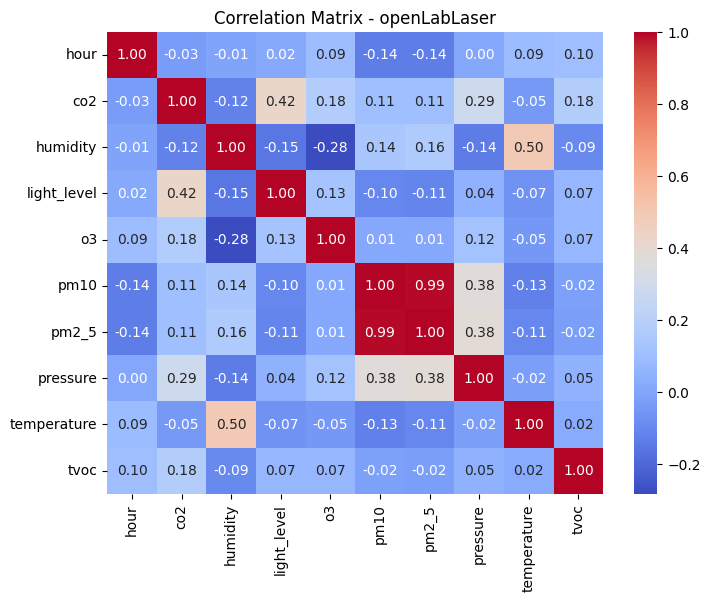

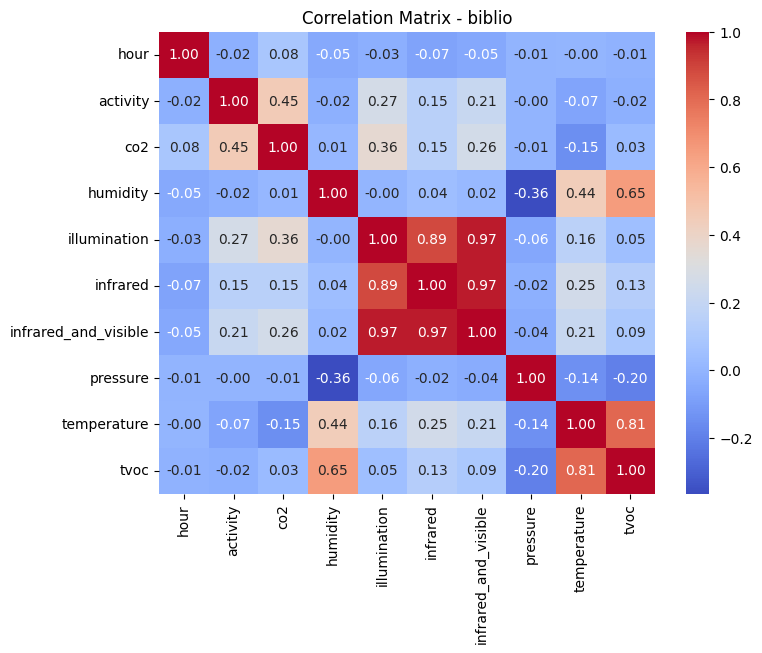

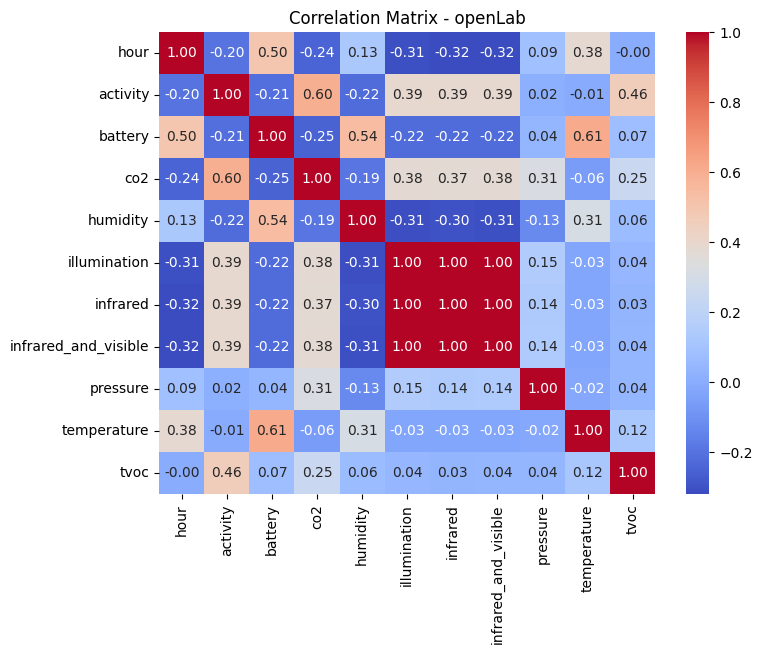

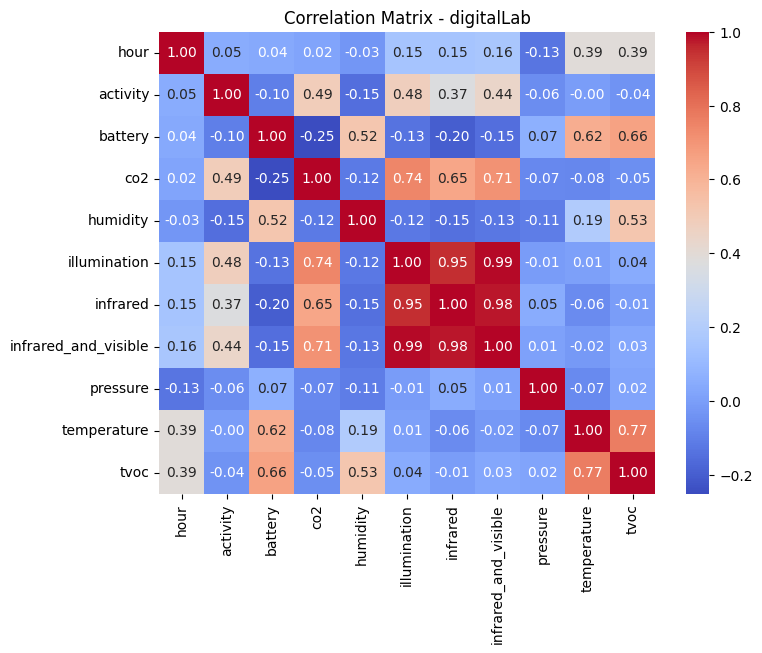

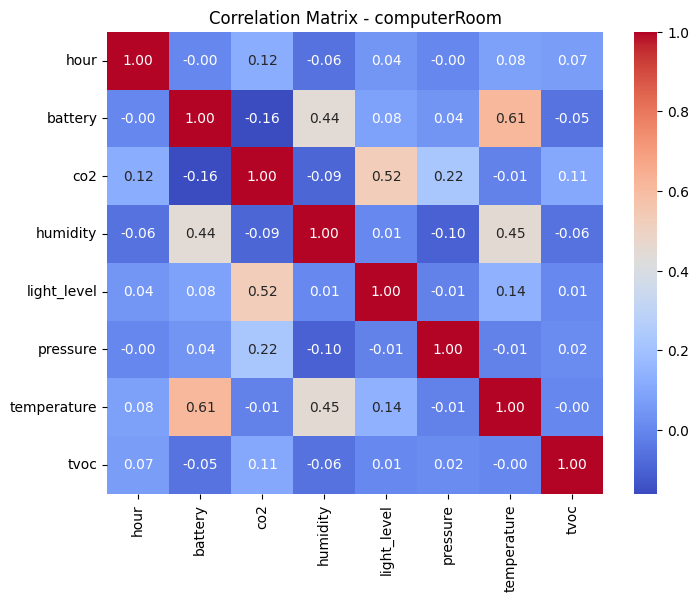

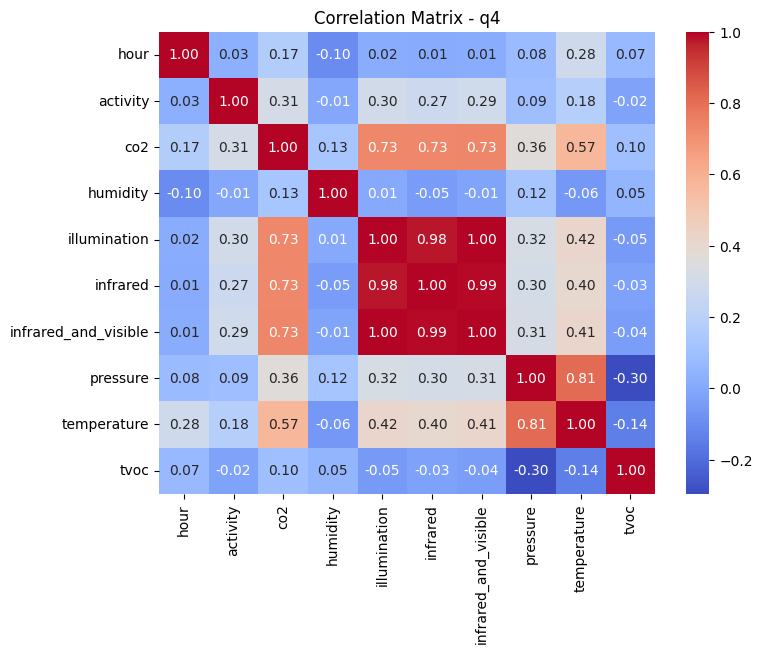

In [49]:
# Define a function for Min-Max scaling
def min_max_scaling(column):
    min_value = column.min()
    max_value = column.max()
    scaled_column = (column - min_value) / (max_value - min_value)
    return scaled_column

# Define dataframes
dataframes = {
    'openLabLaser': sensor_tables['eui-24e124710c408089'], # open lab - laser room
    'biblio': sensor_tables['eui-24e124128c147444'],  # biblio filosofia i lletres
    'openLab': sensor_tables['eui-24e124128c147500'], # OpenLab – Main Room
    'digitalLab': sensor_tables['eui-24e124128c147204'], # OpenLab – Main Room
    'computerRoom': sensor_tables['am307-9074'], # OpenLab – Main Room
    'q4': sensor_tables['q4-1003-7456'] # Q4-1003
}

# Loop through each dataframe
for name, df in dataframes.items():
    # Filter rows where '_field' is not 'battery' for biblio dataframe
    if name == 'biblio':
        df = df[df['_field'] != 'battery']
    if name == 'q4':
        df = df[df['_field'] != 'battery']

    # Pivot table
    pivot_df = df.pivot_table(index=['location', 'date', 'hour'], columns='_field', values='_value').reset_index()

    # Reset column names
    pivot_df.columns.name = None

    # Drop rows containing NaN values
    pivot_df = pivot_df.dropna()

    # Convert 'hour' column to datetime and extract hour component
    pivot_df['hour'] = pd.to_datetime(pivot_df['hour'], format='%H:%M:%S')
    pivot_df['hour'] = pivot_df['hour'].dt.hour

    # Drop 'location' and 'date' columns
    pivot_df = pivot_df.drop(columns=['location', 'date'])

    # Normalize each column using Min-Max scaling
    normalized_df = pivot_df.apply(min_max_scaling)

    # Compute correlation matrix
    correlation_matrix = normalized_df.corr()

    # Plot correlation matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix - {name}')

    # Save plot as image file
    save_pic(f'{name}_correlation_matrix.png')

    # Display the plot
    plt.show()


## Resources


In [50]:
#resources = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/synthesis/recursos_enginyeriaa.xls')

# Correlation of energy consumption and occupation

---
The idea is to create a new dataframe where there is every day and hour in the rank of occupation_hourly, fill all the possible gaps with data already in the occupation datase, fill the extra hours without available data (for example night hours) and add a column of energy consumption

---

## Creation of the merging dataset between occupation and consumption (with all hour slots)

In [51]:
# Find the latest timestamp in the energy_consumption_h DataFrame
last_row = energy_consumption_h.iloc[-1]
last_date = last_row['Date']
last_hour = last_row['Hour']

# Now, let's find the index of the row in the occupation DataFrame
index_to_keep = occupation[(occupation['Data inicial'] == last_date) & (occupation['Hora inicial'] == last_hour)].index[0]

# Now, let's slice the occupation DataFrame
c_occupation = occupation.iloc[:index_to_keep+1].copy()
c_occupation.rename(columns={'Data inicial': 'Date', "Hora inicial": "Hour"}, inplace=True)

c_occupation

,Date,Hour,Alumnes matriculats
0,2018-01-01,15:00:00,0.0
1,2018-01-01,16:00:00,0.0
2,2018-01-03,16:00:00,0.0
3,2018-01-03,17:00:00,0.0
4,2018-01-03,18:00:00,0.0
...,...,...,...
15971,2024-02-13,08:00:00,332.5
15972,2024-02-13,09:00:00,747.0
15973,2024-02-13,10:00:00,818.0
15974,2024-02-13,11:00:00,927.0


In [52]:
c_energy = energy_consumption_h.copy()
c_energy

,Date,Hour,Q-Enginyeria-Total [kWh]
0,2018-01-01,00:00:00,177.000000
1,2018-01-01,01:00:00,177.440000
2,2018-01-01,02:00:00,176.570000
3,2018-01-01,03:00:00,174.980000
4,2018-01-01,04:00:00,174.510000
...,...,...,...
53624,2024-02-13,08:00:00,363.222567
53625,2024-02-13,09:00:00,388.690476
53626,2024-02-13,10:00:00,417.800000
53627,2024-02-13,11:00:00,440.495455


In [53]:
# Merge datasets based on Date and Hour columns.
# By adding the right part, we ensure we are keeping all rows from energy which is the larger dataset
occupation_x_energy_h = pd.merge(c_occupation, c_energy, on=['Date', 'Hour'], how='right')

occupation_x_energy_h

,Date,Hour,Alumnes matriculats,Q-Enginyeria-Total [kWh]
0,2018-01-01,00:00:00,NaN,177.000000
1,2018-01-01,01:00:00,NaN,177.440000
2,2018-01-01,02:00:00,NaN,176.570000
3,2018-01-01,03:00:00,NaN,174.980000
4,2018-01-01,04:00:00,NaN,174.510000
...,...,...,...,...
53624,2024-02-13,08:00:00,332.5,363.222567
53625,2024-02-13,09:00:00,747.0,388.690476
53626,2024-02-13,10:00:00,818.0,417.800000
53627,2024-02-13,11:00:00,927.0,440.495455


In [54]:
occupation_x_energy_h['Alumnes matriculats'] = occupation_x_energy_h['Alumnes matriculats'].fillna(0)

In [55]:
occupation_x_energy_h.rename(columns={"Alumnes matriculats": "Occupation", "Q-Enginyeria-Total [kWh]": "Energy consumption [kwh]"}, inplace=True)

occupation_x_energy_h

,Date,Hour,Occupation,Energy consumption [kwh]
0,2018-01-01,00:00:00,0.0,177.000000
1,2018-01-01,01:00:00,0.0,177.440000
2,2018-01-01,02:00:00,0.0,176.570000
3,2018-01-01,03:00:00,0.0,174.980000
4,2018-01-01,04:00:00,0.0,174.510000
...,...,...,...,...
53624,2024-02-13,08:00:00,332.5,363.222567
53625,2024-02-13,09:00:00,747.0,388.690476
53626,2024-02-13,10:00:00,818.0,417.800000
53627,2024-02-13,11:00:00,927.0,440.495455


In [56]:
# Group by 'Date' and calculate the mean for each day
occupation_x_energy_d = occupation_x_energy_h.copy()

occupation_x_energy_d = occupation_x_energy_d.drop('Hour', axis=1)
occupation_x_energy_d = occupation_x_energy_d.groupby('Date').sum().reset_index()
occupation_x_energy_d

,Date,Occupation,Energy consumption [kwh]
0,2018-01-01,0.0,4574.100000
1,2018-01-02,0.0,4732.650000
2,2018-01-03,0.0,5002.980000
3,2018-01-04,0.0,5012.830000
4,2018-01-05,0.0,4987.020000
...,...,...,...
2230,2024-02-09,0.0,5667.725649
2231,2024-02-10,0.0,2929.404762
2232,2024-02-11,0.0,2840.428571
2233,2024-02-12,4827.0,6278.612381


In [57]:
max = occupation_x_energy_d['Occupation'].max()
max

6425.0

## Check correlation

**hourly** correlation without normalisation


In [58]:
correlation_h = occupation_x_energy_h['Occupation'].corr(occupation_x_energy_h['Energy consumption [kwh]'])
correlation_h  #without normalisation

0.36053825653254684

**daily** correlation without normalisation


In [59]:
correlation_d = occupation_x_energy_d ['Occupation'].corr(occupation_x_energy_d ['Energy consumption [kwh]'])
correlation_d  #without normalisation

0.23710832278007854

In [60]:
min_consumption = occupation_x_energy_d['Energy consumption [kwh]'].min()
min_consumption

2291.41866666675

In [61]:
occupation_x_energy_d_without_base = occupation_x_energy_d.copy()
occupation_x_energy_d_without_base['Energy consumption [kwh]'] -= min_consumption #substract minimum energy consumption value
occupation_x_energy_d_without_base

,Date,Occupation,Energy consumption [kwh]
0,2018-01-01,0.0,2282.681333
1,2018-01-02,0.0,2441.231333
2,2018-01-03,0.0,2711.561333
3,2018-01-04,0.0,2721.411333
4,2018-01-05,0.0,2695.601333
...,...,...,...
2230,2024-02-09,0.0,3376.306983
2231,2024-02-10,0.0,637.986095
2232,2024-02-11,0.0,549.009905
2233,2024-02-12,4827.0,3987.193714


**daily** correlation without normalisation. Base consumption substracted


In [62]:
correlation_d_without_base = occupation_x_energy_d_without_base['Occupation'].corr(occupation_x_energy_d_without_base['Energy consumption [kwh]'])
correlation_d_without_base  #without normalisation. Min consumption value substracted

0.23710832278007854

As observed, the result remains unchanged. This outcome arises from subtracting a fixed value from all rows, resulting in a linear transformation. Such transformations do not affect the core aspect when computing the correlation metric: relative differences.

---
The university occupation varies according to the time period. For
instance, January and June often experience lower faculty occupation due to holidays and exams. Conversely, in July, although students may be absent, the entire faculty requires air conditioning.

To enhance correlation analysis, it's crucial to focus on time spans devoid of exam periods or holidays. This approach ensures a more accurate assessment of occupancy patterns.

The following code analyses the data grouping it by months. This approach allows a better correlation coefficient for those months without 'special' cases.

In [63]:
occupation_x_energy_d

,Date,Occupation,Energy consumption [kwh]
0,2018-01-01,0.0,4574.100000
1,2018-01-02,0.0,4732.650000
2,2018-01-03,0.0,5002.980000
3,2018-01-04,0.0,5012.830000
4,2018-01-05,0.0,4987.020000
...,...,...,...
2230,2024-02-09,0.0,5667.725649
2231,2024-02-10,0.0,2929.404762
2232,2024-02-11,0.0,2840.428571
2233,2024-02-12,4827.0,6278.612381


In [64]:
# Daily analysis

#occupation_x_energy_d_without_base['Date'] = pd.to_datetime(occupation_x_energy_d_without_base['Date'])
#occupation_x_energy_d = pd.to_datetime(occupation_x_energy_d['Date'])

# Create an empty dictionary to store correlation coefficients for each month
month_correlations = {}

# Loop through each month
for month in range(1, 13):
    # Get the name of the month
    month_name = calendar.month_name[month]
    # Filter dataframe for the current month
    month_df = occupation_x_energy_d[occupation_x_energy_d['Date'].dt.month == month]
    # Check if the month has at least one day of data
    if not month_df.empty:
        # Reset index after slicing
        month_df.reset_index(inplace=True)
        # Calculate correlation coefficient
        correlation = month_df['Occupation'].corr(month_df['Energy consumption [kwh]'])
        # Store correlation coefficient in the dictionary
        month_correlations[month_name] = correlation
    else:
        print(f"No data available for month {month_name}")

######################################################################################################################

# Hourly analysis

occupation_x_energy_h['Date'] = pd.to_datetime(occupation_x_energy_h['Date'])

# Create an empty dictionary to store correlation coefficients for each month
month_correlations_hourly = {}

# Loop through each month
for month in range(1, 13):
    # Get the name of the month
    month_name = calendar.month_name[month]
    # Filter dataframe for the current month
    month_df = occupation_x_energy_h[occupation_x_energy_h['Date'].dt.month == month]
    # Check if the month has at least one day of data
    if not month_df.empty:
        # Calculate correlation coefficient
        correlation = month_df['Occupation'].corr(month_df['Energy consumption [kwh]'])
        # Store correlation coefficient in the dictionary
        month_correlations_hourly[month_name] = correlation
    else:
        print(f"No data available for month {month_name}")

/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/martina/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [65]:
print('MONTHLY CORRELATION (daily): Energy consumption - Faculty Q occupation')
# Print correlation coefficients for each month
for month, correlation in month_correlations_hourly.items():
    print(f'{month}: {correlation}')

print('\nMONTHLY CORRELATION (hourly):  Energy consumption - Faculty Q occupation')
# Print correlation coefficients for each month
for month, correlation in month_correlations.items():
    print(f'{month}: {correlation}')

MONTHLY CORRELATION (daily): Energy consumption - Faculty Q occupation
January: 0.26533176500518696
February: 0.5386810070736671
March: 0.5745947754810244
April: 0.5159507456818954
May: 0.4837370993953762
June: 0.04246844685135683
July: nan
August: nan
September: 0.5544243091035141
October: 0.7007871215332048
November: 0.7583885859715713
December: 0.7813559095617683

MONTHLY CORRELATION (hourly):  Energy consumption - Faculty Q occupation
January: 0.3923974775254718
February: 0.5174729028227578
March: 0.5515167546715368
April: 0.4949107179324862
May: 0.3515465785304788
June: -0.040524330435780194
July: nan
August: nan
September: 0.520661707006284
October: 0.7497431543976767
November: 0.7722883943600041
December: 0.8681994592783362


The biggest difference is found in June. That happens because the occupation data is close to 0 during all the month. Analysing it days makes the number of students even smaller since it uses the mean. In this case, hourly approach gets a better perfomance, even if the correlation coefficient is still very low.

In [66]:
start_date = '2022-01-01'
end_date = '2022-12-31'
occupation_x_energy_d2 = occupation_x_energy_d[(occupation_x_energy_d['Date'] >= start_date) & (occupation_x_energy_d['Date'] <= end_date)]
occupation_x_energy_d2


,Date,Occupation,Energy consumption [kwh]
1461,2022-01-01,0.0,2476.495643
1462,2022-01-02,0.0,2422.645310
1463,2022-01-03,0.0,2633.998476
1464,2022-01-04,0.0,2695.938643
1465,2022-01-05,0.0,4568.909071
...,...,...,...
1821,2022-12-27,0.0,2888.777185
1822,2022-12-28,0.0,3312.836320
1823,2022-12-29,0.0,3301.877141
1824,2022-12-30,0.0,3292.226049


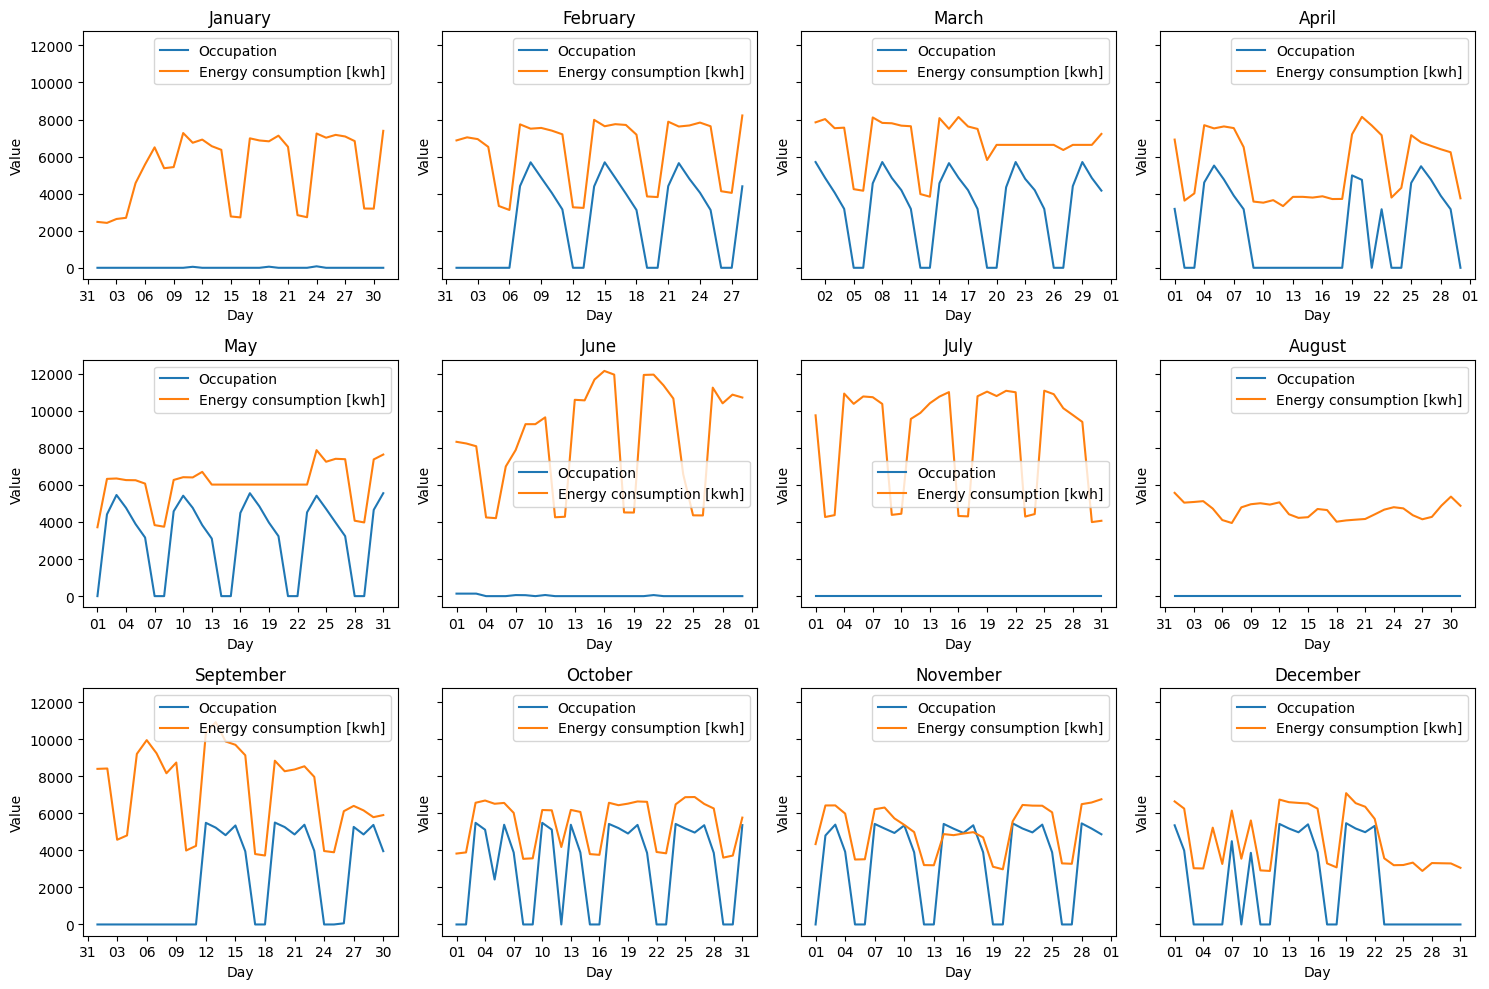

In [67]:
# Calculate the number of subplots needed
num_months = 12
num_rows = 3
num_cols = (num_months + num_rows - 1) // num_rows

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharey=True)

# Flatten the axis array to iterate over them
axs = axs.flatten()

# Loop through each month
for month in range(1, 13):
    # Get the name of the month
    month_name = calendar.month_name[month]
    # Filter dataframe for the current month
    month_df = occupation_x_energy_d2[occupation_x_energy_d2['Date'].dt.month == month]
    # Check if the month has at least one day of data
    if not month_df.empty:
        # Plot occupation and energy consumption
        axs[month - 1].plot(month_df.index, month_df['Occupation'], label='Occupation')
        axs[month - 1].plot(month_df.index, month_df['Energy consumption [kwh]'], label='Energy consumption [kwh]')

        # Simplify x-axis
        axs[month - 1].xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=3))
        axs[month - 1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d'))

        # Add labels and title
        axs[month - 1].set_xlabel('Day')
        axs[month - 1].set_ylabel('Value')
        axs[month - 1].set_title(f'{month_name}')
        axs[month - 1].legend()
    else:
        print(f"No data available for month {month_name}")

# Adjust layout
plt.tight_layout()
save_pic("Daily_EC&Occupation.png")

# Show plot
plt.show()


These graphs provide a clear visualization of key events throughout the year, such as Christmas, winter exams, Easter break, summer exams, and summer holidays, allowing for easy identification of these "special" times.

Weekends are distinctly visible, indicated by a 0 occupation value and lower energy consumption.

In August, the graphs reveal minimal faculty consumption, likely due to reduced presence on campus and deactivated air conditioning systems. The impact of air conditioning on energy consumption is evident in the overall increase in energy usage from May/June to September, with August being the exception.

## Normalization

In [68]:
print(occupation_x_energy_h['Occupation'].dtype)
print(occupation_x_energy_h['Energy consumption [kwh]'].dtype)

float64
float64


In [69]:
# Define a function for Min-Max scaling
def min_max_scaling(column):
    min_value = column.min()
    max_value = column.max()
    scaled_column = (column - min_value) / (max_value - min_value)
    return scaled_column

# Normalize selected columns using Min-Max scaling
occupation_x_energy_h_norm = occupation_x_energy_h.copy()
occupation_x_energy_h_norm["Occupation"] = min_max_scaling(occupation_x_energy_h["Occupation"])
occupation_x_energy_h_norm["Energy consumption [kwh]"] = min_max_scaling(occupation_x_energy_h["Energy consumption [kwh]"])

occupation_x_energy_h_norm

,Date,Hour,Occupation,Energy consumption [kwh]
0,2018-01-01,00:00:00,0.000000,0.163364
1,2018-01-01,01:00:00,0.000000,0.163854
2,2018-01-01,02:00:00,0.000000,0.162885
3,2018-01-01,03:00:00,0.000000,0.161113
4,2018-01-01,04:00:00,0.000000,0.160589
...,...,...,...,...
53624,2024-02-13,08:00:00,0.246114,0.370889
53625,2024-02-13,09:00:00,0.552924,0.399270
53626,2024-02-13,10:00:00,0.605477,0.431709
53627,2024-02-13,11:00:00,0.686158,0.457001


## Check normalised correlation

In [70]:
correlation_norm = occupation_x_energy_h_norm['Occupation'].corr(occupation_x_energy_h_norm['Energy consumption [kwh]'])
correlation_norm

0.3605382565325468

The result is the same as before. This happens because the correlation is only checked between the occupation column and energy consumption.
Normalising is important when checking the correlation between x column and many different columns (if not done, the column with the highest values would have the biggest correlation coefficient).

# Correlation of PV and temperature/weather

# Prediction

First and foremost it is crucial to determine the parameters to predict.
Considering there is real-time data (temperature, Tvoc, illumination...) acquisition, in order to give useful warnings on the website, it would be adventageous to predict:

* **PV production** (based on weather forecasts and historical PV production data).
    - These could be useful for example to anticipate when is it optimal to do certain activities that require more equipment than usual
* **Energy consumption** (based on  historical data, class occupation)
    - It is always essential to remember energy-saving actions during peak consumption times and/or when renewable energy sources are available
* **Outdoor temperature, humidity, and sunlight intensity based on weather forecasts**
     - In order to give suggestions for indoor temperature regulation and natural ventilation based on outdoor conditions.
* **Occupancy Patterns**
    - Anticipating class occupancy based on historical data and schedules allows for optimized resource allocation and energy management. Recommendations can be tailored to accommodate varying occupancy levels efficiently. For example, if in the evenings there are fewer classes, organize all of them near each other to turn off the lights in other hallways.


---



(Ja se que molts no es podran fer o tindran una accuracy baixa pero ho apunto i despres ja direm perq no hem fet alguns)

---


Once that's settled, the following step is to train and test different models and choose those with higher performances that fit the intended purpose.
Given the nature of the project, some of the first options are:
* **Linear regression**: Predicting continuous variables such as PV production, energy consumption, and outdoor temperature.
    - Linear regression is a simple and interpretable model that can provide baseline predictions for continuous variables. It can be effective when there's a linear relationship between input features and the target variable.
* **Decision Trees**: Predicting occupancy patterns and providing recommendations for resource allocation.
    - Decision trees can handle both numerical and categorical data, making them suitable for predicting occupancy patterns based on historical data and schedules. They also provide interpretability, which is valuable for understanding the decision-making process.
* **Random Forests**: Predicting PV production, energy consumption, and outdoor conditions.
    - Random forests are an ensemble learning method that combines multiple decision trees, resulting in improved predictive performance and robustness. They can handle both regression and classification tasks and are effective for handling noisy data.
* **Gradient Boosting Machines (GBM)**: Predicting PV production, energy consumption, and occupancy patterns.
    - GBM is a powerful ensemble learning technique that sequentially trains weak learners to correct errors made by previous models. It often achieves higher predictive accuracy compared to other algorithms and is suitable for handling complex relationships in the data.
* **Convolutional Neural Networks (CNNs)**: Analyzing image data such as outdoor conditions (e.g., sunlight intensity).
    - Reason: CNNs are well-suited for processing spatial data like images. They automatically learn hierarchical features from the data, making them effective for tasks involving pattern recognition and classification. In your case, they could analyze outdoor images to estimate sunlight intensity.
* **Multi-Layer Neural Networks**: Predicting complex relationships between input features and target variables.
    - Multi-layer neural networks are capable of learning nonlinear relationships in the data. They can capture intricate patterns and interactions, making them suitable for tasks where the relationships between predictors and the target are not easily linearly separable.



---

To start the modelling proces, the first step of the implementation is to split the data in training, validation and test. As in this project there are several datasets, it is more convenient to create a function

In [128]:
RANDOM_SEED = 42

In [72]:
def split_train_val_test (X, y, size = 0.3, random_state = RANDOM_SEED):
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state = RANDOM_SEED)
  # REMEMBER WE ARE SPLITTING IN HALF TO HAVE HALF OF VALIDATION AND HALF OF TEST
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state = RANDOM_SEED)
  return X_train, y_train, X_val, y_val, X_test, y_test

In [73]:
# Split our data (60/20/20) or (70/15/15).
occupation_x_energy_d_without_base.rename(columns={"Energy consumption [kwh]": "Energy Consumption"}, inplace=True)

X = occupation_x_energy_d_without_base.drop(["Energy Consumption", "Date"], axis=1)  # Features
y = occupation_x_energy_d_without_base["Energy Consumption"]  # Target

X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test (X, y)
X

,Occupation
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2230,0.0
2231,0.0
2232,0.0
2233,4827.0


## Data normalization


## Prediction with functions of consumption based on other weekdays from the same month of previous years

In [129]:
'''
prediction_df_h = occupation_x_energy_h.copy()
prediction_df = occupation_x_energy_d.copy()

# Add a 'week_day' column
prediction_df['Week_day'] = prediction_df['Date'].dt.day_name()
prediction_df['Month'] = prediction_df['Date'].dt.month_name()
prediction_df
'''
oce_h = occupation_x_energy_h.copy()
oce_d = occupation_x_energy_d.copy()

# Add a 'week_day' column
oce_d['Week_day'] = oce_d['Date'].dt.day_name()
oce_d['Month'] = oce_d['Date'].dt.month_name()
save_csv (oce_d, "occupation_energy_daily.csv")
#oce_d

oce_h['Week_day'] = oce_h['Date'].dt.day_name()
oce_h['Month'] = oce_h['Date'].dt.month_name()
oce_h["Hour"] = pd.to_datetime(oce_h["Date"].astype(str) + ' ' + oce_h["Hour"].astype(str)).dt.hour
save_csv (oce_h, "occupation_energy_hourly.csv")
#oce_h


### Prediction function


In [130]:
# Read the CSV file into a dataframe
oce_d = pd.read_csv("CSVs/occupation_energy_daily.csv")
oce_h = pd.read_csv("CSVs/occupation_energy_hourly.csv")
oce_d['Date'] = pd.to_datetime(oce_d['Date'])
oce_h['Date'] = pd.to_datetime(oce_h['Date'])

In [131]:
def predict_energy_occupation(df, result_mode, month, week_day, hour=None):
    # Filter the DataFrame for the given month, week day, and optionally hour
    if hour is None:
        filtered_df = df[(df['Month'] == month) & (df['Week_day'] == week_day)]
    else:
        filtered_df = df[(df['Month'] == month) & (df['Week_day'] == week_day) & (df['Hour'] == hour)]

    # Calculate the average energy consumption or occupation
    if not filtered_df.empty:
        if result_mode == 'energy':
            avg_value = filtered_df['Energy consumption [kwh]'].mean()
            avg_value = avg_value * (1 if hour is None else 0.8)
        elif result_mode == 'occupation':
            period_mask = (filtered_df['Date'] >= pd.Timestamp('2020-01-09')) & (filtered_df['Date'] <= pd.Timestamp('2022-01-07'))
            filtered_df.loc[period_mask, 'Occupation'] *= 2
            avg_value = filtered_df['Occupation'].mean()
        else:
            return "No data available for the specified month, week day, and hour" if hour else \
                   "No data available for the specified month and week day"
        return avg_value
    else:
        return "No data available for the specified month, week day, and hour" if hour else \
               "No data available for the specified month and week day"

def predict_until(df, df_mode, result_mode, end_date):
    # Generate a date range from the next day/hour after the last date in the df to the end_date
    start_value = df['Date'].max() + pd.Timedelta(days=1) if df_mode == 'daily' else df['Date'].max() + pd.Timedelta(hours=1)
    date_range = pd.date_range(start=start_value, end=end_date, freq='D' if df_mode == 'daily' else 'h')

    # Create a DataFrame with the date range
    future_dates = pd.DataFrame(date_range, columns=['Date'])
    future_dates['Week_day'] = future_dates['Date'].dt.day_name()
    future_dates['Month'] = future_dates['Date'].dt.month_name()
    if df_mode == 'hourly':
        future_dates['Hour'] = future_dates['Date'].dt.hour

    # Predict energy consumption or occupation for each future date and optionally hour
    predictions = []
    for _, row in future_dates.iterrows():
        month = row['Month']
        week_day = row['Week_day']
        hour = row['Hour'] if df_mode == 'hourly' else None
        prediction = predict_energy_occupation(df, result_mode, month, week_day, hour)
        predictions.append(prediction)

    future_dates['predicted_' + result_mode] = predictions
    return future_dates

In [132]:
def visualise_prediction(df, df_mode, result_mode):
  '''
    df: dataframe containing the predictions
    df_mode: hourly or daily forecast
    result_mode: occupation or energy forecast
  '''
  plt.figure(figsize=(10, 6))
  dates = df['Date']
  if result_mode == 'energy':
    plt.plot(dates, df['predicted_energy'], label='Predicted '+ result_mode, color='red')
  elif result_mode == 'occupation':
    plt.plot(dates, df['predicted_occupation'], label='Predicted Data ' + result_mode, color='lightgreen')
  if df_mode == 'daily':
    p = len(df)//15
  elif df_mode == 'hourly':
    p = len(df)//24
  plt.xticks(dates[::p], rotation=45)
  plt.title(df_mode + ' ' + result_mode + ' forecast')
  plt.xlabel('Date')
  plt.ylabel(result_mode)
  plt.legend()
  plt.grid(True)
  save_pic(df_mode + ' ' + result_mode + ' forecast'+'.png')
  plt.show()

In [133]:
def visualise_prediction_true(df, df_mode, result_mode, true_df):
  '''
    df: dataframe containing the predictions
    df_mode: hourly or daily forecast
    result_mode: occupation or energy forecast
    true_df: true data
  '''
  plt.figure(figsize=(10, 6))
  dates = df['Date']

  if df_mode == 'daily':
    p = len(df)//15
  elif df_mode == 'hourly':
    p = len(df)//24

  if result_mode == 'energy':
    plt.plot(dates, df['predicted_energy'], label='Predicted '+ result_mode, color='red')
    plt.plot(dates, true_df['Energy consumption [kwh]'], label='True '+ result_mode, color='lightblue')
  elif result_mode == 'occupation':
    plt.plot(dates, df['predicted_occupation'], label='Predicted Data ' + result_mode, color='lightgreen')
    plt.plot(dates, true_df['Occupation'], label='True Data ' + result_mode, color='lightblue')

  plt.xticks(dates[::p], rotation=45)
  plt.title(df_mode + ' ' + result_mode + ' forecast')
  plt.xlabel('Date')
  plt.ylabel(result_mode)
  plt.legend()
  plt.grid(True)
  save_pic(df_mode + ' ' + result_mode + ' forecast'+'.png')
  plt.show()

In [134]:
def prediction (df, df_mode, result_mode, end_date):
  prediction = predict_until(df, df_mode, result_mode, end_date)
  visualise_prediction(prediction, df_mode, result_mode)
  return prediction

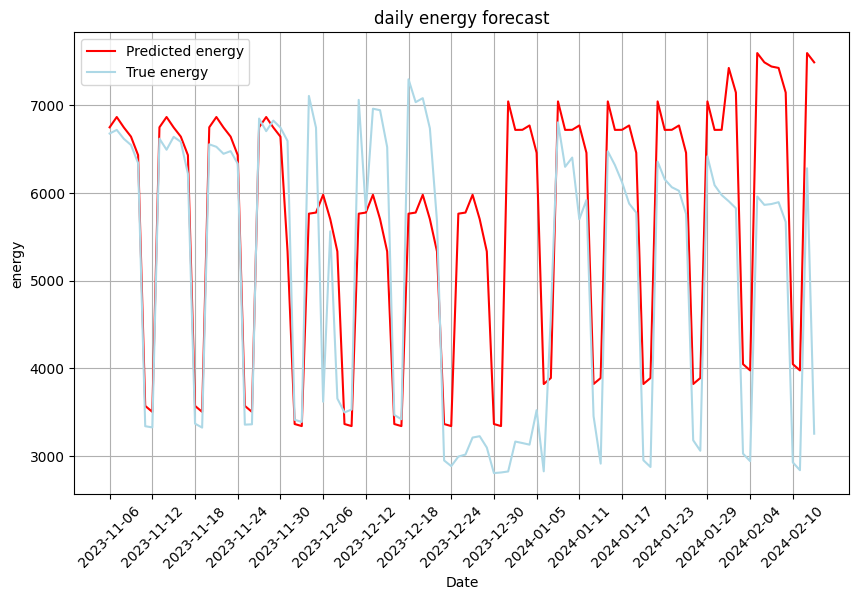

In [135]:
period = oce_d[:-100].reset_index()
plot = oce_d[-100:].reset_index()

df_mode = 'daily'
result_mode = 'energy'

predicted_data_d = predict_until(period, df_mode, result_mode, '2024-02-13')
visualise_prediction_true(predicted_data_d, df_mode, result_mode, plot)

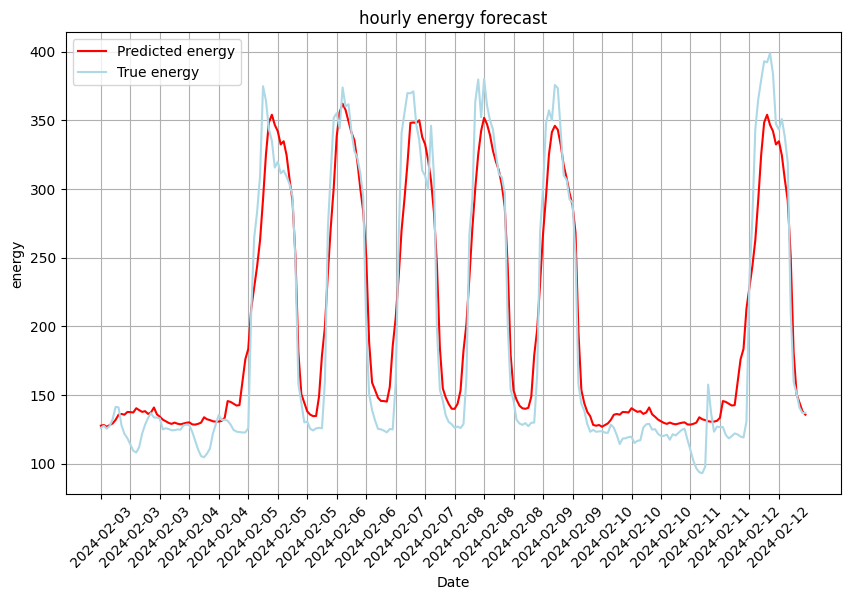

In [136]:
plot_h = oce_h[-252:-12].reset_index()
period_h = oce_h[:-240]

df_mode = 'hourly'
result_mode = 'energy'

predicted_data_h = predict_until(period_h, df_mode, result_mode, '2024-02-13')
visualise_prediction_true(predicted_data_h, df_mode, result_mode, plot_h)

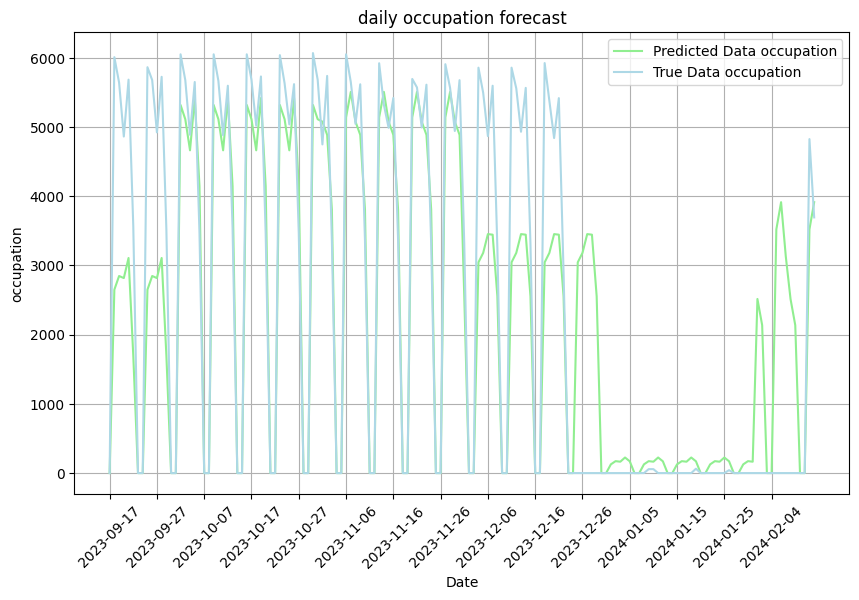

In [137]:
plot_d = oce_d[-150:].reset_index()
period_d = oce_d[:-150]

df_mode = 'daily'
result_mode = 'occupation'

predicted_data_d = predict_until(period_d, df_mode, result_mode, '2024-02-13')
visualise_prediction_true(predicted_data_d, df_mode, result_mode, plot_d)

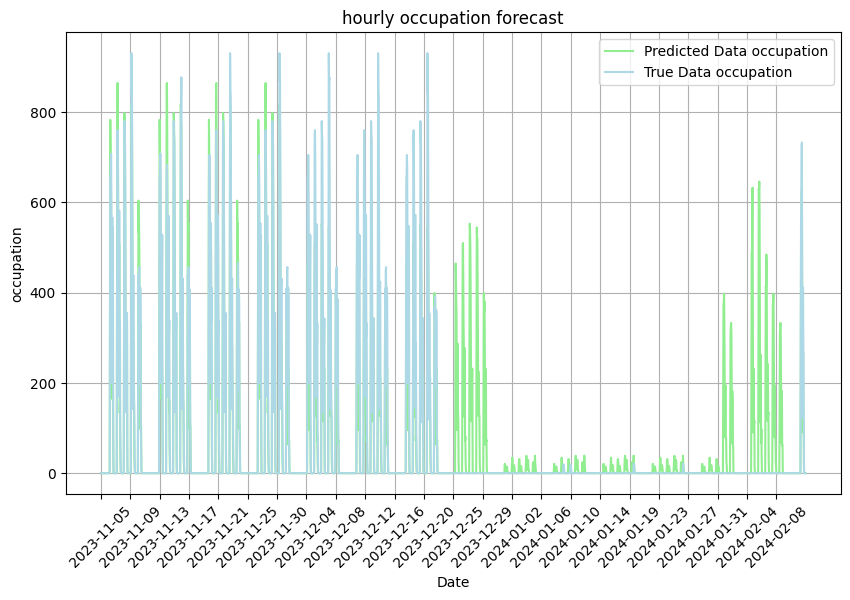

In [138]:
plot_h = oce_h[-2412:-12].reset_index()
period_h = oce_h[:-2400]

df_mode = 'hourly'
result_mode = 'occupation'

predicted_data_h = predict_until(period_h, df_mode, result_mode, '2024-02-13')
visualise_prediction_true(predicted_data_h, df_mode, result_mode, plot_h)

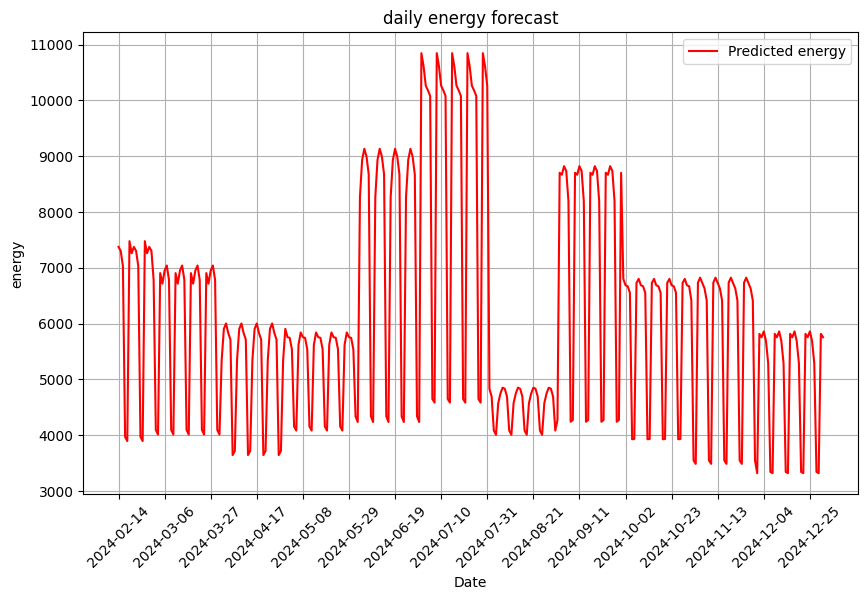

In [139]:
df_mode = 'daily'
df_result = 'energy'
forecast_date = '2024-12-31'
pred = prediction (oce_d, df_mode, df_result, forecast_date)

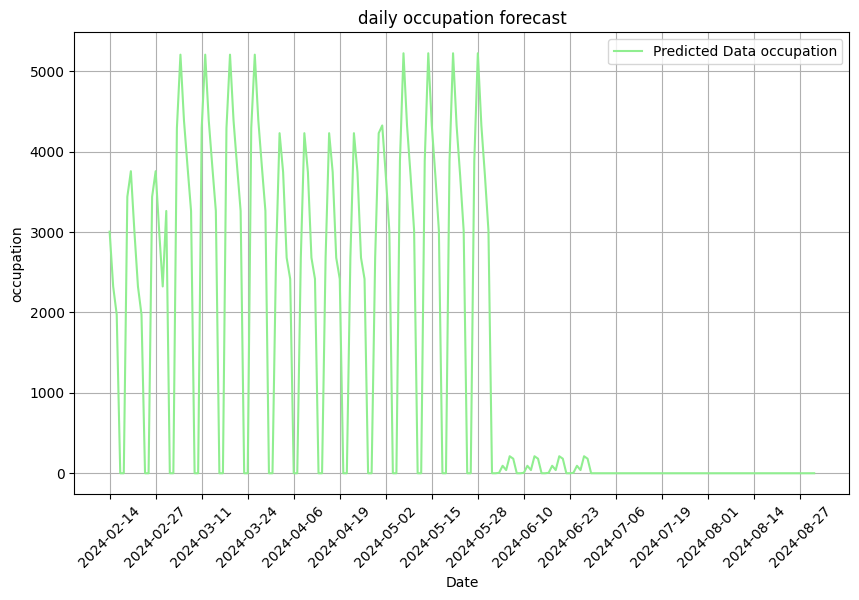

In [140]:
df_mode = 'daily'
df_result = 'occupation'
forecast_date = '2024-08-31'
pred = prediction (oce_d, df_mode, df_result, forecast_date)

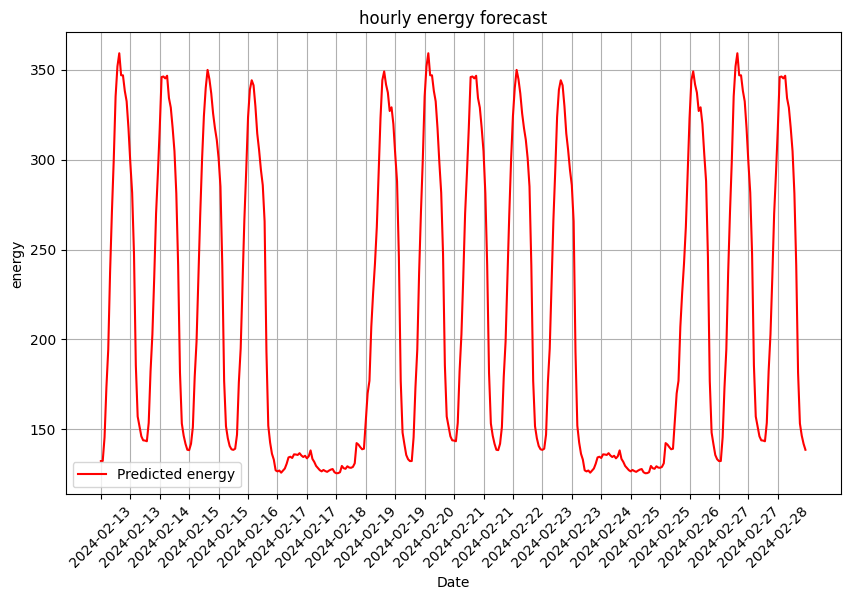

In [141]:
df_mode = 'hourly'
df_result = 'energy'
forecast_date = '2024-02-29'
pred = prediction (oce_h, df_mode, df_result, forecast_date)

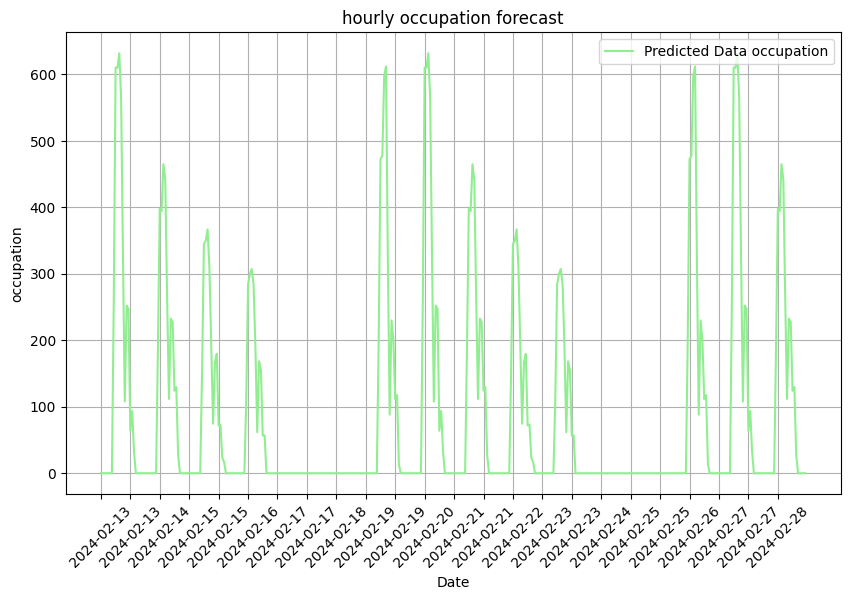

In [142]:
df_mode = 'hourly'
df_result = 'occupation'
forecast_date = '2024-02-29'
pred = prediction (oce_h, df_mode, df_result, forecast_date)

## Model functions

### SARIMA

In [74]:
mec = energy_consumption_m[:-12] # Select alll rows except for the last 12 months

In [75]:
# SARIMA model requires specifying parameters such as
# p (autoregression order), d (differencing order), q (moving average order), P, D, Q (seasonal components), and s (seasonal period).

# Define SARIMA parameters
p, d, q = 1, 2, 1
P, D, Q, s = 2, 1, 1, 12 # Assuming monthly seasonality

# Fit the SARIMA model which works greatly when there is an importance of the time and certain seasons
model = SARIMAX(mec['Q-Enginyeria-Total [kWh]'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model


/home/martina/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29333D+00    |proj g|=  4.24810D-01

At iterate    5    f=  9.17592D+00    |proj g|=  4.42860D-02

At iterate   10    f=  9.16757D+00    |proj g|=  2.65942D-03

At iterate   15    f=  9.16746D+00    |proj g|=  3.13369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   9.577D-06   9.167D+00
  F =   9.1674567572080221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


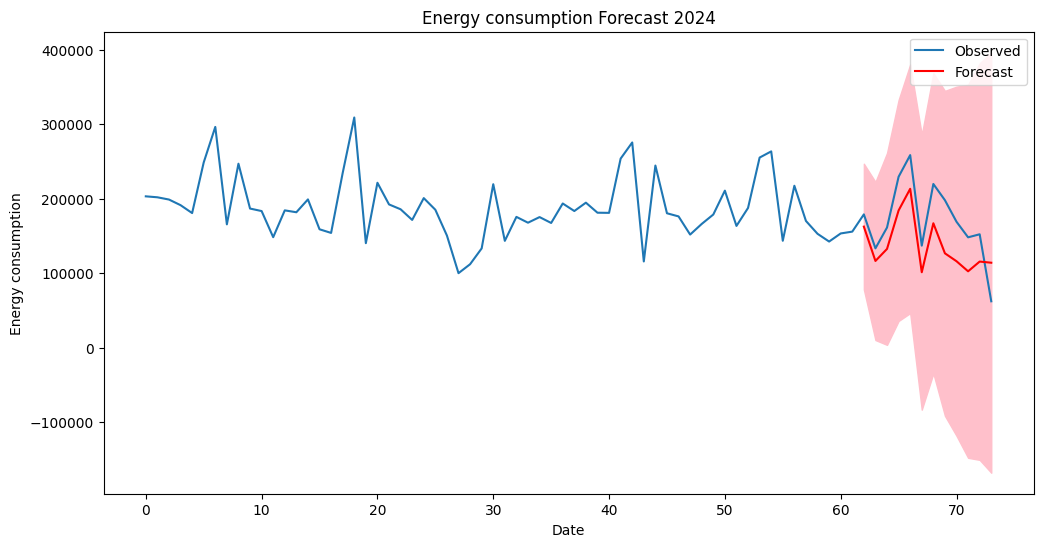

<Figure size 640x480 with 0 Axes>

In [76]:
# Forecast future values
forecast_periods = 12 # Forecast the next 1 year
forecast = results.get_forecast(steps=forecast_periods)

# Extract mean confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(energy_consumption_m['Q-Enginyeria-Total [kWh]'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Energy consumption Forecast 2024")
plt.xlabel("Date")
plt.ylabel("Energy consumption")
plt.legend()
#plt.savefig('Energy consumption forecast.png')
plt.show()
save_pic("Energy_consumption_forecast.png")

In [97]:
# Extract the last 60 forecasted values
last_60_forecast_mean = forecast_mean.iloc[:]

# Calculate MSE
mse = ((energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]'] - last_60_forecast_mean) ** 2).mean()

# Calculate RMSE
rmse = np.sqrt(((energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]'] - last_60_forecast_mean) ** 2).mean())

# Calculate MAE
mae = np.abs(energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]'] - last_60_forecast_mean).mean()

# Calculate SMAPE
smape = (np.mean(np.abs(energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]'] - last_60_forecast_mean)) /
         (np.mean(energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]']) + np.mean(last_60_forecast_mean))) * 200

# Calculate R-squared
r_squared = r2_score(energy_consumption_m[-12:]['Q-Enginyeria-Total [kWh]'], last_60_forecast_mean)

print("Mean Squared Error (MSE) between the last 60 observed and forecasted values:", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)
print("R-squared (R²):", r_squared)


Mean Squared Error (MSE) between the last 60 observed and forecasted values: 1959639930.0488784
Root Mean Squared Error (RMSE): 44267.82047999289
Mean Absolute Error (MAE): 41602.13959828579
Symmetric Mean Absolute Percentage Error (SMAPE): 26.992542537265056
R-squared (R²): 0.20514703861713357


SARIMA (Seasonal Autoregressive Integrated Moving Average) forecasts energy consumption by analyzing patterns and trends in past data. It considers seasonal patterns, autocorrelation (how each observation relates to its past values), and moving averages (patterns in recent data points). By fitting a SARIMA model to historical energy consumption data, the algorithm learns the underlying patterns and uses them to make predictions. This model accounts for both short-term fluctuations and long-term trends, providing a comprehensive forecast based on past information.

The confidence interval (CI) around the forecasted mean (red line) represents the range of likely outcomes for energy consumption, given the model's uncertainty. A narrower CI indicates higher confidence in the forecast, while a wider CI suggests greater uncertainty. The forecast provides not only a point estimate but also a range of possible values, helping to assess the reliability of predictions. It accounts for variability in the data and uncertainty in the model's parameters.

### Random forest regressor

In [78]:
model_d = occupation_x_energy_d.copy() # occupation_x_energy_m
model_d

,Date,Occupation,Energy consumption [kwh]
0,2018-01-01,0.0,4574.100000
1,2018-01-02,0.0,4732.650000
2,2018-01-03,0.0,5002.980000
3,2018-01-04,0.0,5012.830000
4,2018-01-05,0.0,4987.020000
...,...,...,...
2230,2024-02-09,0.0,5667.725649
2231,2024-02-10,0.0,2929.404762
2232,2024-02-11,0.0,2840.428571
2233,2024-02-12,4827.0,6278.612381


Now let's convert this dataframe so that the Date column only displays the year and add two columns:
- Month
- Weekday
These will be one-hot vectors.
The model is supposed to be trained with the whole dataset. Once that is done, it will receive as input a date (year, month and day) and occupation, and return the predicted energy consumption 

In [79]:
original_dates = model_d['Date'] # Save the original date so that the one-hot encoding does not affect it and we can afterwards create the plot

model_d['date'] = pd.to_datetime(model_d['Date'])

# Extract year from date
model_d['year'] = model_d['date'].dt.year

# Extract month and weekday, then perform one-hot encoding
model_d['month'] = model_d['date'].dt.month
model_d['weekday'] = model_d['date'].dt.weekday

model_d = pd.get_dummies(model_d, columns=['month', 'weekday'])

# Drop the original 'Date' column
model_d = model_d.drop(columns=['Date'])
model_d = model_d.drop(columns=['date'])
model_d

,Occupation,Energy consumption [kwh],year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.0,4574.100000,2018,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,0.0,4732.650000,2018,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.0,5002.980000,2018,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0.0,5012.830000,2018,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.0,4987.020000,2018,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,0.0,5667.725649,2024,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2231,0.0,2929.404762,2024,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2232,0.0,2840.428571,2024,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2233,4827.0,6278.612381,2024,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [80]:
original_dates 

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
2230   2024-02-09
2231   2024-02-10
2232   2024-02-11
2233   2024-02-12
2234   2024-02-13
Name: Date, Length: 2235, dtype: datetime64[ns]

In [104]:
X = model_d.drop('Energy consumption [kwh]', axis=1)
y = model_d['Energy consumption [kwh]']

# Divide in 70/30 ratio
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Calculate the index at which to split the data
split_index = int(len(X) * 0.7)

# Split the data
X_train = X[:split_index]
X_val = X[split_index:]
y_train = y[:split_index]
y_val = y[split_index:]
# X_val

Random forest regressor would be a good choice. It can handle mixing categorical (one-hot encoded date) and numerical features.

In [106]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Train the model using the best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# Validate the model
y_pred_forest = best_rf.predict(X_val)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


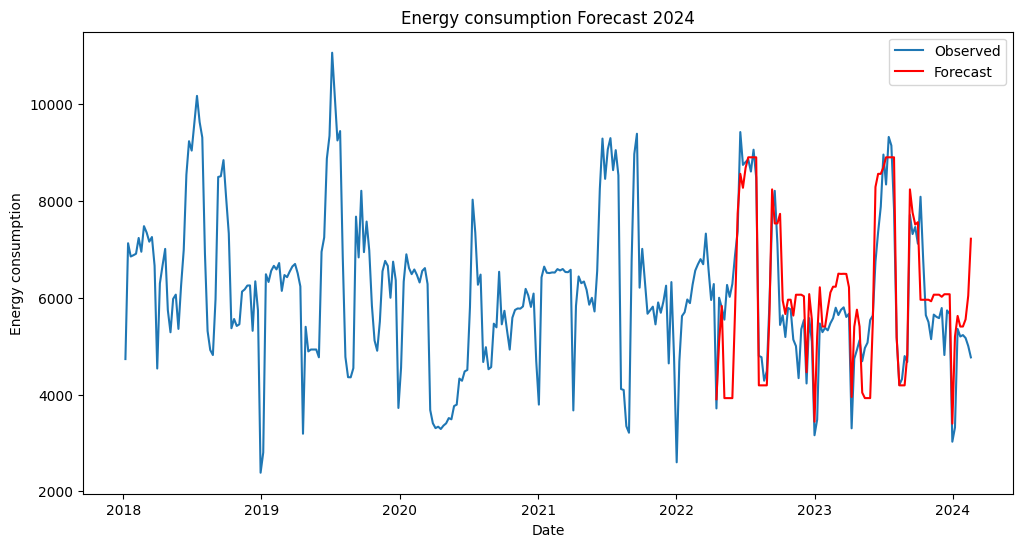

<Figure size 640x480 with 0 Axes>

In [107]:
df_predictions = pd.DataFrame({
    'date': original_dates[split_index:],  # select the dates corresponding to your validation set
    'prediction': y_pred_forest
})

# Convert 'date' column to datetime and set it as index
df_predictions['date'] = pd.to_datetime(df_predictions['date'])
df_predictions.set_index('date', inplace=True)

# Resample the data to weekly mean
df_predictions_resampled = df_predictions.resample('W').mean()

# Do the same for the observed data
energy_consumption_resampled = energy_consumption_d.copy()
energy_consumption_resampled['Date'] = pd.to_datetime(energy_consumption_resampled['Date'])
energy_consumption_resampled.set_index('Date', inplace=True)
energy_consumption_resampled = energy_consumption_resampled['Q-Enginyeria-Total [kWh]'].resample('W').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(energy_consumption_resampled, label='Observed')
plt.plot(df_predictions_resampled, label='Forecast', color='red')
plt.title("Energy consumption Forecast 2024")
plt.xlabel("Date")
plt.ylabel("Energy consumption")
plt.legend()
plt.show()
save_pic("Energy_consumption_forecast_d_forest.png")


In [98]:
# Calculate the errors
mae2 = mean_absolute_error(y_val, y_pred_forest)
mse2 = mean_squared_error(y_val, y_pred_forest)
rmse2 = sqrt(mse2)

print(f'Mean Absolute Error (MAE): {mae2}')
print(f'Mean Squared Error (MSE): {mse2}')
print(f'Root Mean Squared Error (RMSE): {rmse2}')

Mean Absolute Error (MAE): 873.1556132917751
Mean Squared Error (MSE): 1443458.0128558674
Root Mean Squared Error (RMSE): 1201.4399747202801


### Gradient boost

In [113]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Create a base model
gb = GradientBoostingRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Train the model using the best parameters
best_gb = GradientBoostingRegressor(**grid_search.best_params_)
best_gb.fit(X_train, y_train)

# Validate the model
y_pred_gb = best_gb.predict(X_val)

{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


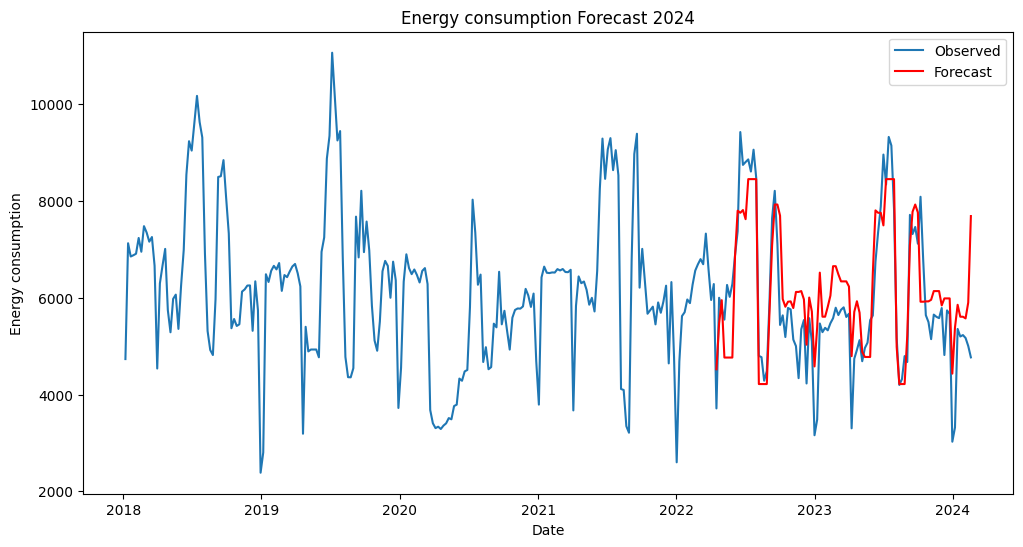

<Figure size 640x480 with 0 Axes>

In [109]:
df_predictions = pd.DataFrame({
    'date': original_dates[split_index:],  # select the dates corresponding to your validation set
    'prediction': y_pred_gb
})

# Convert 'date' column to datetime and set it as index
df_predictions['date'] = pd.to_datetime(df_predictions['date'])
df_predictions.set_index('date', inplace=True)

# Resample the data to weekly mean
df_predictions_resampled = df_predictions.resample('W').mean()

# Do the same for the observed data
energy_consumption_resampled = energy_consumption_d.copy()
energy_consumption_resampled['Date'] = pd.to_datetime(energy_consumption_resampled['Date'])
energy_consumption_resampled.set_index('Date', inplace=True)
energy_consumption_resampled = energy_consumption_resampled['Q-Enginyeria-Total [kWh]'].resample('W').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(energy_consumption_resampled, label='Observed')
plt.plot(df_predictions_resampled, label='Forecast', color='red')
plt.title("Energy consumption Forecast 2024")
plt.xlabel("Date")
plt.ylabel("Energy consumption")
plt.legend()
plt.show()
save_pic("Energy_consumption_forecast_d_gb.png")


In [114]:
# Calculate the errors
mae_gb = mean_absolute_error(y_val, y_pred_gb)
mse_gb = mean_squared_error(y_val, y_pred_gb)
rmse_gb = sqrt(mse_gb)

print(f'Mean Absolute Error (MAE): {mae_gb}')
print(f'Mean Squared Error (MSE): {mse_gb}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb}')

Mean Absolute Error (MAE): 951.8081525302334
Mean Squared Error (MSE): 1502299.6631172816
Root Mean Squared Error (RMSE): 1225.683345369954


### Extreme gradient boost

In [115]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}

# Create a base model
xg_reg = xgb.XGBRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Train the model using the best parameters
best_xg_reg = xgb.XGBRegressor(**grid_search.best_params_)
best_xg_reg.fit(X_train, y_train)

# Validate the model
y_pred_xgb = best_xg_reg.predict(X_val)

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}


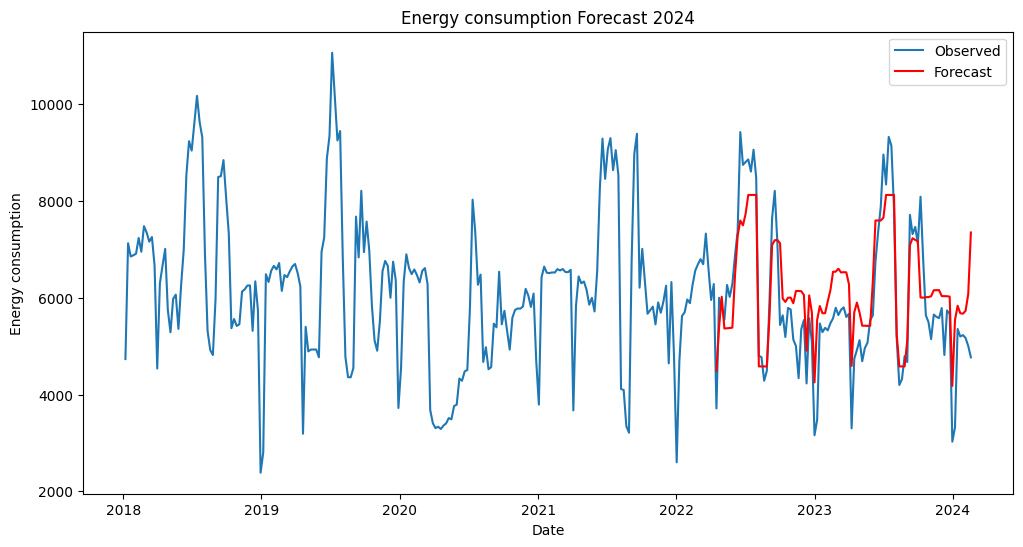

<Figure size 640x480 with 0 Axes>

In [111]:
df_predictions = pd.DataFrame({
    'date': original_dates[split_index:],  # select the dates corresponding to your validation set
    'prediction': y_pred_xgb
})

# Convert 'date' column to datetime and set it as index
df_predictions['date'] = pd.to_datetime(df_predictions['date'])
df_predictions.set_index('date', inplace=True)

# Resample the data to weekly mean
df_predictions_resampled = df_predictions.resample('W').mean()

# Do the same for the observed data
energy_consumption_resampled = energy_consumption_d.copy()
energy_consumption_resampled['Date'] = pd.to_datetime(energy_consumption_resampled['Date'])
energy_consumption_resampled.set_index('Date', inplace=True)
energy_consumption_resampled = energy_consumption_resampled['Q-Enginyeria-Total [kWh]'].resample('W').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(energy_consumption_resampled, label='Observed')
plt.plot(df_predictions_resampled, label='Forecast', color='red')
plt.title("Energy consumption Forecast 2024")
plt.xlabel("Date")
plt.ylabel("Energy consumption")
plt.legend()
plt.show()
save_pic("Energy_consumption_forecast_d_xgb.png")

In [116]:
# Calculate and print the metrics
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
rmse_xgb = sqrt(mse_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost MAE: 909.7494686942692
XGBoost MSE: 1376700.5614563755
XGBoost RMSE: 1173.3288377332142


## Evaluation of the models

In [127]:
evaluation_ml = pd.DataFrame({
    'Model': ['SARIMA', 'Random Forest Regressor', 'Gradient Boost', 'Extreme Gradient Boost'],
    'MAE': [mae, mae2, mae_gb, mae_xgb],
    'MSE': [mse, mse2, mse_gb, mse_xgb],
    'RMSE': [rmse, rmse2, rmse_gb, rmse_xgb]
})

evaluation_ml

,Model,MAE,MSE,RMSE
0,SARIMA,41602.139598,1.959640e+09,44267.820480
1,Random Forest Regressor,873.155613,1.443458e+06,1201.439975
2,Gradient Boost,951.808153,1.502300e+06,1225.683345
3,Extreme Gradient Boost,909.749469,1.376701e+06,1173.328838


If the objective is a model that makes the smallest average error, you would choose the model with the smallest Mean Absolute Error (MAE). In this case, the Random Forest Regressor has the smallest MAE.

If the objective is a model that is the most accurate on average, you would choose the model with the smallest Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). These metrics penalize larger errors more than smaller ones. In this case, the Random Forest Regressor also has the smallest MSE and RMSE.

## Deep learning models:

# Function to zip all folders

This function is used for better comit and synch with github

In [151]:
import shutil

def zip_and_delete_directory(dir_path):
    # Check if directory exists
    if os.path.exists(dir_path):
        # If it exists, create a zip archive and delete the directory
        if dir_path != 'datasets': # The datasets.zip already exists, no need to cxonvert it again
            shutil.make_archive(dir_path, 'zip', dir_path)
        shutil.rmtree(dir_path)

zip_and_delete_directory('figures')
zip_and_delete_directory('datasets')
